#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
# import julia;
# julia.install()

In [2]:
import numpy as np
import numdifftools as nd
import math
import matplotlib.pyplot as plt
from datetime import datetime
# from scipy.integrate import odeint
# from torchdiffeq import odeint
import torch
import inspect
import random
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
import scipy
from numpy import linalg as LA

In [3]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [4]:
# from diffeqpy import ode
# from diffeqpy import de

In [5]:
from vehicles import shipClarke83
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [6]:
from sympy import *

In [7]:
def R2D(value):  # radians to degrees
    return value * 180 / math.pi

In [8]:
mp = 96 #  (submerged) [kg/m]

In [9]:
node_N=4

In [10]:
# diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
diag_Irho = 1e15*np.array([1, 1, 2]) # [m^4]  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
 
Irho=np.diag(diag_Irho)

In [11]:
Irho

array([[1.e+15, 0.e+00, 0.e+00],
       [0.e+00, 1.e+15, 0.e+00],
       [0.e+00, 0.e+00, 2.e+15]])

In [12]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]

In [13]:
diag_DT = 1.5*np.array([1, 1, 1]) # [N/m]  , p.99 in [1]

In [14]:
DT=np.diag(diag_DT) # (35) in [2]

In [15]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [16]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [17]:
CT=np.diag(diag_CT)

In [18]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [19]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [20]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [21]:
rng = np.random.default_rng()

In [22]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [23]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [24]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[ 0.13158202,  0.17121995, -0.97640663],
       [ 0.13006932,  0.97347315,  0.18823388],
       [ 0.98273503, -0.15176874,  0.1058211 ]])

In [25]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.001122


In [26]:
Ret

array([[[ 0.13158202,  0.17121995, -0.97640663],
        [ 0.13006932,  0.97347315,  0.18823388],
        [ 0.98273503, -0.15176874,  0.1058211 ]],

       [[ 0.09679852,  0.26024427,  0.96067839],
        [-0.3866287 ,  0.89924343, -0.20464483],
        [-0.91714137, -0.35161652,  0.18766334]],

       [[-0.67196347, -0.71612315, -0.18876632],
        [ 0.35930361, -0.5381239 ,  0.76244579],
        [-0.64758475,  0.4445113 ,  0.61890523]],

       [[ 0.94748841, -0.15859005, -0.2776957 ],
        [-0.07210323,  0.74006462, -0.66865947],
        [ 0.3115555 ,  0.65356986,  0.68976779]]])

In [27]:
Ret.shape

(4, 3, 3)

In [28]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [29]:
def C1(dx,dy,dz, Ret):
    B=np.vstack([dx**2,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
#     print(np.dot(Ret[0],B.T[0]))
    ans=np.einsum('ijk,ik->ij', Ret,B.T)
    return ans.T

In [30]:
dx**2

array([0.08308018, 2.7070857 , 1.30039639, 2.0392781 ])

In [31]:
C1(dx,dy,dz,Ret)

array([[ 2.32543845,  0.05065757, -3.53199876,  3.56116937],
       [ 0.66967478, -1.65123998, -0.95393047, -1.56547062],
       [-0.3154562 , -2.25021509,  1.12761626, -4.64688992]])

In [32]:
C1(dx,dy,dz,Ret).shape

(3, 4)

In [33]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000413


In [34]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [35]:
1/2*d0*qw*np.dot(DT,C1(dx,dy,dz,Ret).T[0])*9.81

array([13345.77017711,  3843.28629799, -1810.41382048])

In [36]:
fD(dx,dy,dz,DT,Ret)

array([[ 13345.77017711,    290.7255379 , -20270.26072405,
         20437.67189218],
       [  3843.28629799,  -9476.52228578,  -5474.63935868,
         -8984.28904155],
       [ -1810.41382048, -12914.0607632 ,   6471.42796415,
        -26668.65895148]])

In [37]:
fD(dx,dy,dz,DT,Ret).T

array([[ 13345.77017711,   3843.28629799,  -1810.41382048],
       [   290.7255379 ,  -9476.52228578, -12914.0607632 ],
       [-20270.26072405,  -5474.63935868,   6471.42796415],
       [ 20437.67189218,  -8984.28904155, -26668.65895148]])

In [38]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000270


In [39]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [40]:
I=np.identity(3)

In [41]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000217


In [42]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [43]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [44]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [45]:
DR=np.diag(diag_DR) 

In [46]:
dI= 0.69# Inner diameter of pipe, [m]

In [47]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [48]:
Ar

0.08091250419136858

In [49]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [50]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223]])

In [51]:
# # not checked 
# def k_sigma(hi,d0,fg_e):
#     ans=[]
#     for it in hi:
#         if it<0:
#             ans.append(0)
#         elif 0<=it<=d0/20:
#             ans.append(np.float64(LA.norm(fg_e,2)/(d0/8-d0/40)*10*it**2/d0))
#         else:
#             ans.append(np.float64(LA.norm(fg_e,2)/(d0/8-d0/40)*(it-d0/40)))     
#     return np.array(ans).reshape(node_N,1)   

In [52]:
x,y,z=100*rng.standard_normal(node_N),100*rng.standard_normal(node_N),100*rng.standard_normal(node_N)

In [53]:
# # not checked
# def hi(x,y,z,d0):
#     return (np.dot(np.array([x,y,z]).T,[0,0,1])+d0/2).reshape(node_N,1) 

In [54]:
# startTime1 = datetime.now()
# hi(x,y,z,d0)
# print(datetime.now() - startTime1)

In [55]:
# k_sigma(hi(x,y,z,d0),d0,fg_e)

In [56]:
# startTime1 = datetime.now()
# k_sigma(hi(x,y,z,d0),d0,fg_e)
# print(datetime.now() - startTime1)

In [57]:
# # TODO: force shoud be acting only at nodes that are in contact with the seabed
# # not checked
# def sigma(x,y,z):
#     return (k_sigma(hi(x,y,z,d0),d0,fg_e)*np.array([0,0,1]))

In [58]:
# startTime1 = datetime.now()
# sigma(x,y,z)
# print(datetime.now() - startTime1)

In [59]:
def Re_b(Ret):
#     return np.dot(Ret, Rb_t ) # (5) in[3]
    return Ret

In [60]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000079


In [61]:
def phi(x, y, z, Ret):
    B=np.vstack([x,y,z])
    return np.einsum('ijk,ik->ij', Ret,B.T)

In [62]:
phi(x,y,z,Ret)

array([[  48.83786371, -222.14144795,   77.50593913],
       [ -52.2741501 , -212.40132093,    9.57491346],
       [ -39.46798709,   67.92897475, -125.53970675],
       [ -59.17806356,   66.69714386,  126.92553771]])

In [63]:
# def d_s(da,db,dc,x,y,z):

#     ds=np.sqrt(np.diff(x,prepend=x[0])**2+np.diff(y,prepend=y[0])**2
#                  +np.diff(z,prepend=z[0])**2)
#     ds[ds == 0] = 1
#     return np.vstack([np.diff(da,prepend=da[0])/ds,np.diff(db,prepend=db[0])/ds,np.diff(dc,prepend=dc[0])/ds])

In [64]:
startTime1 = datetime.now()
phi(x,y,z,Ret)
print(datetime.now() - startTime1)

0:00:00.000248


In [65]:
def d_s(f,a,b,c,Ret):
#     ds=np.sqrt(np.diff(a,prepend=a[0])**2+np.diff(b,prepend=b[0])**2
#                  +np.diff(c,prepend=c[0])**2)
    ds=np.sqrt(np.diff(a)**2+np.diff(b)**2+np.diff(c)**2)
#     ds[ds == 0] = 1
    fun = f(a,b,c,Ret)
    ans=(np.diff(fun,axis=0) / ds.reshape(node_N-1,1)).T
    return np.insert(ans, -1, 1.1*ans[:,-1], axis=1)

In [66]:
# def d_s(f,a,c,Ret):
# #     ds=np.sqrt(np.diff(a,prepend=a[0])**2+np.diff(c,prepend=c[0])**2)
#     ds=np.sqrt(np.diff(a)**2+np.diff(c)**2)
# #     ds[ds == 0] = 1
#     fun = f(a,c,Ret)
# #     ans=(np.diff(fun,prepend=fun[0].reshape(1,2),axis=0) / ds.reshape(node_N,1)).T
#     ans=(np.diff(fun,axis=0) / ds.reshape(node_N-1,1)).T
#     np.insert(ans, -1, ans[:,-1], axis=1)
#     return np.insert(ans, -1, 1.1*ans[:,-1], axis=1)

In [67]:
d_s(phi,x,y,z,Ret)

array([[-1.2864869 ,  0.08103853, -0.08080557, -0.07345961],
       [ 0.12392737,  1.77395491, -0.00505015, -0.00459104],
       [-0.86431248, -0.85501727,  1.03503388,  0.94093989]])

In [68]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret)
print(datetime.now() - startTime1)

0:00:00.000316


In [69]:
def ne(x,y,z,Ret):
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret).T
    return np.einsum('ijk,ik->ij', A,B)

In [70]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [71]:
# sigma(x,y,z)

In [72]:
ne_(dx,dy,dz,DT,Ret)

array([[-13345.77017711,   -290.7255379 ,  20270.26072405,
        -20437.67189218],
       [ -3843.28629799,   9476.52228578,   5474.63935868,
          8984.28904155],
       [  1682.24927825,  12785.89622097,  -6599.59250638,
         26540.49440925]])

In [73]:
# mp*ddp = d_s(ne,ds)+np.dot(Re_b,ne_)

In [74]:
startTime1 = datetime.now()
ne(x,y,z,Ret)
print(datetime.now() - startTime1)

0:00:00.000343


In [75]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000401


In [76]:
Re_b(Ret).shape

(4, 3, 3)

In [77]:
def Irho_e(Ret):
    return np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 

In [78]:
Irho_e(Ret)

array([[[1.73138287e+13, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 9.47649978e+14, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 2.23962122e+13]],

       [[9.36995338e+12, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 8.08638741e+14, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 7.04350564e+13]],

       [[4.51534906e+14, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 2.89577328e+14, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 7.66087377e+14]],

       [[8.97734294e+14, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 5.47695636e+14, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 9.51559219e+14]]])

In [79]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000186


In [80]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [81]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [82]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.001240


In [83]:
def ωe(φ,θ,ψ, dummy):  # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T)

In [84]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None)
print(datetime.now() - startTime1)

0:00:00.000420


In [85]:
ωe(φ,θ,ψ,None)

array([[ 0.20947902, -2.15123265, -1.13055949],
       [-0.55860454,  2.18469893, -1.0240278 ],
       [-1.1494849 ,  1.61476132,  1.27077642],
       [ 0.70651444, -0.39682655,  0.32817951]])

In [86]:
diag_CR = 1e11*np.array([1, 1, 1]) 
CR=np.diag(diag_CR)

In [87]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [88]:
def d_me(φ,θ,ψ,Ret):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(ωe,φ,θ,ψ,None)
    return np.einsum('ijk,ik->ij', A,B.T) 

In [89]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret)
print(datetime.now() - startTime1)

0:00:00.001169


In [90]:
d_me_

array([[-4.07793603e+08,  1.25999611e+11,  3.65815607e+07],
       [-1.31733249e+08, -1.09657988e+10,  1.92292756e+09],
       [ 3.38438377e+10, -2.35241545e+10, -1.45809151e+10],
       [ 6.11706937e+10, -4.04479078e+10, -1.64645404e+10]])

In [91]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [92]:
# np.dot(Re_b, np.dot( Irho_e, (np.dot(Π(φ,θ,ψ), np.array([ddφ,ddθ,ddψ])))))=
# -np.dot(Re_b,np.dot(Irho_e,np.dot(Π(dφ,dθ,dψ),np.array([dφ,dθ,dψ])))-
# np.cross(np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ])),np.dot(Irho_e, np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))+
# np.dot(Re_b,d_s(me_[0],me_[1],me_[2],dt,ds)+d_s(me_[0],me_[1],me_[2],dt,ds))+
# np.cross(d_s(x,y,z,dt,ds),ne(x,y,z,φ,θ,ψ,dt,ds))+
# np.dot(Re_b,-np.dot(DR,np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))

In [93]:
ne_(dx,dy,dz,DT,Ret)

array([[-13345.77017711,   -290.7255379 ,  20270.26072405,
        -20437.67189218],
       [ -3843.28629799,   9476.52228578,   5474.63935868,
          8984.28904155],
       [  1682.24927825,  12785.89622097,  -6599.59250638,
         26540.49440925]])

In [94]:
C=ne(x,y,z,Ret)
  
a,b,c=C[:,0],C[:,1],C[:,2]

In [95]:
Re_b(Ret).shape

(4, 3, 3)

In [96]:
ne_(dx,dy,dz,DT, Ret).T

array([[-13345.77017711,  -3843.28629799,   1682.24927825],
       [  -290.7255379 ,   9476.52228578,  12785.89622097],
       [ 20270.26072405,   5474.63935868,  -6599.59250638],
       [-20437.67189218,   8984.28904155,  26540.49440925]])

In [97]:
type(x),y,z,dx,type(dy),dz

(numpy.ndarray,
 array([-219.6496978 , -207.9712377 ,  -64.09408399,  141.69995389]),
 array([-81.29839641,  -4.95495367, -18.45479392,  59.3849651 ]),
 array([0.28823633, 1.64532237, 1.14034924, 1.42803295]),
 numpy.ndarray,
 array([-1.39454234, -0.04324732,  0.33584563, -1.31752766]))

In [98]:
ne_(dx,dy,dz,DT,Ret).T+np.einsum('ijk,ik->ij', Re_b(Ret),ne_(dx,dy,dz,DT,Ret).T)

array([[-17402.44023931,  -9003.84126172, -10671.79841048],
       [ 14430.477482  ,  15494.05793341,  12119.87480897],
       [  3974.6507265 ,   4779.95133932, -21377.28754121],
       [-48597.12925276,   -639.68725646,  44351.66412983]])

In [99]:
ne_(dx,dy,dz,DT,Ret).T

array([[-13345.77017711,  -3843.28629799,   1682.24927825],
       [  -290.7255379 ,   9476.52228578,  12785.89622097],
       [ 20270.26072405,   5474.63935868,  -6599.59250638],
       [-20437.67189218,   8984.28904155,  26540.49440925]])

### Vessel

In [100]:
class VesselSemisub: # Semisub model from Fossen
    
    def __init__(self):
        
        MRB = 1.0e10 * np.array(
            [
                [0.0027, 0, 0, 0, -0.0530, 0],
                [0, 0.0027, 0, 0.0530, 0, -0.0014],
                [0, 0, 0.0027, 0, 0.0014, 0],
                [0, 0.0530, 0, 3.4775, 0, -0.0265],
                [-0.0530, 0, 0.0014, 0, 3.8150, 0],
                [0, -0.0014, 0, -0.0265, 0, 3.7192],
            ],
            float,
        )

        MA = 1.0e10 * np.array(
            [
                [0.0017, 0, 0, 0, -0.0255, 0],
                [0, 0.0042, 0, 0.0365, 0, 0],
                [0, 0, 0.0021, 0, 0, 0],
                [0, 0.0365, 0, 1.3416, 0, 0],
                [-0.0255, 0, 0, 0, 2.2267, 0],
                [0, 0, 0, 0, 0, 3.2049],
            ],
            float,
        )

        self.D = 1.0e09 * np.array(
            [
                [0.0004, 0, 0, 0, -0.0085, 0],
                [0, 0.0003, 0, 0.0067, 0, -0.0002],
                [0, 0, 0.0034, 0, 0.0017, 0],
                [0, 0.0067, 0, 4.8841, 0, -0.0034],
                [-0.0085, 0, 0.0017, 0, 7.1383, 0],
                [0, -0.0002, 0, -0.0034, 0, 0.8656],
            ],
            float,
        )

        self.G = 1.0e10 * np.diag([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.M = MRB + MA

    def eq_left(self,η, dη):
        return (np.matmul(self.D, dη) + np.dot(self.G,η))
        
    def tau(self,η, dη, ddη):
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.dot(self.G,η))

In [101]:
V=VesselSemisub()

In [102]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [103]:
tau_force = V.tau(η,dη, ddη)

In [104]:
tau_force

array([0.00000e+00, 0.00000e+00, 2.40000e+06, 7.14800e+09, 1.57272e+10,
       0.00000e+00])

In [105]:
class VesselOtter: 
    
    def __init__(
        self, 
        controlSystem="stepInput", 
        r = 0, 
        V_current = 0, 
        beta_current = 0,
        tau_X = 120
    ):
        
        # Constants
        D2R = math.pi / 180     # deg2rad
        self.g = 9.81           # acceleration of gravity (m/s^2)
        rho = 1026              # density of water (kg/m^3)

        if controlSystem == "headingAutopilot":
            self.controlDescription = (
                "Heading autopilot, psi_d = "
                + str(r)
                + " deg"
                )
        else:
            self.controlDescription = "Step inputs for n1 and n2"
            controlSystem = "stepInput"

        self.ref = r
        self.V_c = V_current
        self.beta_c = beta_current * D2R
        self.controlMode = controlSystem
        self.tauX = tau_X  # surge force (N)

        # Initialize the Otter USV model
        self.T_n = 1.0  # propeller time constants (s)
        self.L = 2.0    # Length (m)
        self.B = 1.08   # beam (m)
        self.nu = np.array([0, 0, 0, 0, 0, 0], float)  # velocity vector
        self.u_actual = np.array([0, 0], float)  # propeller revolution states
        self.name = "Otter USV (see 'otter.py' for more details)"

        self.controls = [
            "Left propeller shaft speed (rad/s)",
            "Right propeller shaft speed (rad/s)"
        ]
        self.dimU = len(self.controls)

        # Vehicle parameters
        m = 55.0                                 # mass (kg)
        self.mp = 25.0                           # Payload (kg)
        self.m_total = m + self.mp
        self.rp = np.array([0.05, 0, -0.35], float) # location of payload (m)
        rg = np.array([0.2, 0, -0.2], float)     # CG for hull only (m)
        rg = (m * rg + self.mp * self.rp) / (m + self.mp)  # CG corrected for payload
        self.S_rg = Smtrx(rg)
        self.H_rg = Hmtrx(rg)
        self.S_rp = Smtrx(self.rp)

        R44 = 0.4 * self.B  # radii of gyration (m)
        R55 = 0.25 * self.L
        R66 = 0.25 * self.L
        T_yaw = 1.0         # time constant in yaw (s)
        Umax = 6 * 0.5144   # max forward speed (m/s)

        # Data for one pontoon
        self.B_pont = 0.25  # beam of one pontoon (m)
        y_pont = 0.395      # distance from centerline to waterline centroid (m)
        Cw_pont = 0.75      # waterline area coefficient (-)
        Cb_pont = 0.4       # block coefficient, computed from m = 55 kg

        # Inertia dyadic, volume displacement and draft
        nabla = (m + self.mp) / rho  # volume
        self.T = nabla / (2 * Cb_pont * self.B_pont * self.L)  # draft
        Ig_CG = m * np.diag(np.array([R44 ** 2, R55 ** 2, R66 ** 2]))
        self.Ig = Ig_CG - m * self.S_rg @ self.S_rg - self.mp * self.S_rp @ self.S_rp

        # Experimental propeller data including lever arms
        self.l1 = -y_pont  # lever arm, left propeller (m)
        self.l2 = y_pont  # lever arm, right propeller (m)
        self.k_pos = 0.02216 / 2  # Positive Bollard, one propeller
        self.k_neg = 0.01289 / 2  # Negative Bollard, one propeller
        self.n_max = math.sqrt((0.5 * 24.4 * self.g) / self.k_pos)  # max. prop. rev.
        self.n_min = -math.sqrt((0.5 * 13.6 * self.g) / self.k_neg) # min. prop. rev.

        # MRB_CG = [ (m+mp) * I3  O3      (Fossen 2021, Chapter 3)
        #               O3       Ig ]
        MRB_CG = np.zeros((6, 6))
        MRB_CG[0:3, 0:3] = (m + self.mp) * np.identity(3)
        MRB_CG[3:6, 3:6] = self.Ig
        MRB = self.H_rg.T @ MRB_CG @ self.H_rg
        

        # Hydrodynamic added mass (best practice)
        Xudot = -0.1 * m
        Yvdot = -1.5 * m
        Zwdot = -1.0 * m
        Kpdot = -0.2 * self.Ig[0, 0]
        Mqdot = -0.8 * self.Ig[1, 1]
        Nrdot = -1.7 * self.Ig[2, 2]

        self.MA = -np.diag([Xudot, Yvdot, Zwdot, Kpdot, Mqdot, Nrdot])

        # System mass matrix
        self.M = MRB + self.MA
        self.Minv = np.linalg.inv(self.M.astype(np.float32))

        # Hydrostatic quantities (Fossen 2021, Chapter 4)
        Aw_pont = Cw_pont * self.L * self.B_pont  # waterline area, one pontoon
        I_T = (
            2
            * (1 / 12)
            * self.L
            * self.B_pont ** 3
            * (6 * Cw_pont ** 3 / ((1 + Cw_pont) * (1 + 2 * Cw_pont)))
            + 2 * Aw_pont * y_pont ** 2
        )
        I_L = 0.8 * 2 * (1 / 12) * self.B_pont * self.L ** 3
        KB = (1 / 3) * (5 * self.T / 2 - 0.5 * nabla / (self.L * self.B_pont))
        BM_T = I_T / nabla  # BM values
        BM_L = I_L / nabla
        KM_T = KB + BM_T    # KM values
        KM_L = KB + BM_L
        KG = self.T - rg[2]
        GM_T = KM_T - KG    # GM values
        GM_L = KM_L - KG

        G33 = rho * self.g * (2 * Aw_pont)  # spring stiffness
        G44 = rho * self.g * nabla * GM_T
        G55 = rho * self.g * nabla * GM_L
        G_CF = np.diag([0, 0, G33, G44, G55, 0])  # spring stiff. matrix in CF
        LCF = -0.2
        H = Hmtrx(np.array([LCF, 0.0, 0.0]))  # transform G_CF from CF to CO
        self.G = H.T @ G_CF @ H

        # Natural frequencies
        w3 = math.sqrt(G33 / self.M[2, 2])
        w4 = math.sqrt(G44 / self.M[3, 3])
        w5 = math.sqrt(G55 / self.M[4, 4])

        # Linear damping terms (hydrodynamic derivatives)
        Xu = -24.4 *self. g / Umax  # specified using the maximum speed
        Yv = 0
        Zw = -2 * 0.3 * w3 * self.M[2, 2]  # specified using relative damping
        Kp = -2 * 0.2 * w4 * self.M[3, 3]
        Mq = -2 * 0.4 * w5 * self.M[4, 4]
        Nr = -self.M[5, 5] / T_yaw  # specified by the time constant T_yaw

        self.D = -np.diag([Xu, Yv, Zw, Kp, Mq, Nr])

        # Propeller configuration/input matrix
        B = self.k_pos * np.array([[1, 1], [-self.l1, -self.l2]])
        self.Binv = np.linalg.inv(B.astype(np.float32))

        # Heading autopilot
        self.e_int = 0  # integral state
        self.wn = 1.2  # PID pole placement
        self.zeta = 0.8

        # Reference model
        self.r_max = 10 * math.pi / 180  # maximum yaw rate
        self.psi_d = 0  # angle, angular rate and angular acc. states
        self.r_d = 0
        self.a_d = 0
        self.wn_d = self.wn / 5  # desired natural frequency in yaw
        self.zeta_d = 1  # desired relative damping ratio
    
    
    def eq_left(self,η, dη):
        
        CRB_CG = np.zeros((6, 6))
        CRB_CG[0:3, 0:3] = self.m_total * Smtrx(dη[3:6])
        CRB_CG[3:6, 3:6] = -Smtrx(np.matmul(self.Ig, dη[3:6]))
        CRB = self.H_rg.T @ CRB_CG @ self.H_rg  # transform CRB from CG to CO

        CA = m2c(self.MA, dη)
        CA[5, 0] = 0  # assume that the Munk moment in yaw can be neglected
        CA[5, 1] = 0  # if nonzero, must be balanced by adding nonlinear damping
        CA[0, 5] = 0
        CA[1, 5] = 0

        C = CRB + CA

        return (np.matmul(self.D, dη) + np.matmul(C, dη) + np.dot(self.G,η))
        
    def tau(self,η, dη, ddη):

        
        CRB_CG = np.zeros((6, 6))
        CRB_CG[0:3, 0:3] = self.m_total * Smtrx(dη[3:6])
        CRB_CG[3:6, 3:6] = -Smtrx(np.matmul(self.Ig, dη[3:6]))
        CRB = self.H_rg.T @ CRB_CG @ self.H_rg  # transform CRB from CG to CO

        CA = m2c(self.MA, dη)
        CA[5, 0] = 0  # assume that the Munk moment in yaw can be neglected
        CA[5, 1] = 0  # if nonzero, must be balanced by adding nonlinear damping
        CA[0, 5] = 0
        CA[1, 5] = 0

        C = CRB + CA
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.matmul(C, dη)+ np.dot(self.G,η))
    

In [106]:
V=VesselOtter()

In [107]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [108]:
tau_force = V.tau(η,dη, ddη)

In [109]:
tau_force

array([   0.        ,    0.        , 3925.3734    ,  484.24424147,
       2251.69893789,    0.        ])

In [110]:
np.matmul(np.array([[1.1,1.2],[1,2]]),np.array([1,2]))

array([3.5, 5. ])

In [111]:
V=VesselSemisub()

In [112]:
# wave_force=9e6
# wave_force=9e3
# wave_force=0
# kp, kd=1.95e9,1.5e9
kp,kd=1.95e4, 1.5e4
# kp,kd=1.95, 1.5
wave_coef=1
# kp,kd=1.95e16, 1.5e16

In [113]:
def Fx(x,dx, kp, kd, x_ref = 0, dx_ref=0):
    return -kp*(x-x_ref) - kd*(dx-dx_ref)

In [114]:
Hs = 2.5 # significant wave height in m

In [115]:
def wave_force(Hs,d0,qw, Cd=1.2):
    g=9.81 
    return 0.5 * qw * g * Hs**2 * d0 * Cd

In [116]:
wave_force(Hs,d0,qw, Cd=1.2)

28695.1696875

In [117]:
η

array([0.1, 0.3, 0.4, 0.5, 0.6, 0.7])

In [118]:
def tau(η, dη, wave_coef, kp, kd,time, Hs=2.5, Tp=10, x_ref = 0, dx_ref=0):
    x,y,z,φ,θ,ψ=η
    dx,dy,dz,dφ,dθ,dψ=dη
    F=(np.array([-Fx(x,dx, kp, kd, x_ref, dx_ref),0,0])
       +wave_coef*np.array([0,0,wave_force(Hs,d0,qw)])*np.sin(2*np.pi/Tp*time+1)
      ).T
    Ret=Re_t_([φ,θ,ψ])
    
    return  np.concatenate([np.dot(Re_b(Ret), F),[0,0,0]], axis=0)

In [119]:
tau(η, dη, wave_coef, kp, kd,3)

array([ 5343.61087893, -1375.87391098,  5138.79058033,     0.        ,
           0.        ,     0.        ])

### Static solution

In [120]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [121]:
pipe_weight_per_unit_length = mp #  (submerged) [kg/m]  # 113.07 - not submerged

In [122]:
Fx_0=82945396

In [123]:
Ws = pipe_weight_per_unit_length*9.81 # [N/m]
h=700

In [124]:
S=math.sqrt(h*(2*Fx_0/Ws -h))
horizontal_length=(Fx_0/Ws -h)*np.log((S+Fx_0/Ws)/(Fx_0/Ws-h))

In [125]:
delta_x=horizontal_length/(node_N-1)

In [126]:
x0=[i*delta_x for i in range(node_N)]
z0=[]
for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws,Fx_0))

In [127]:
x0,z0

([0.0, 3684.228281487207, 7368.456562974414, 11052.68484446162],
 [0.0, 77.06804644731459, 308.40705929683963, 694.4218951076863])

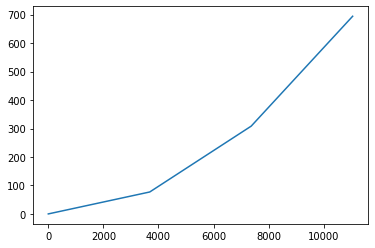

In [128]:
plt.plot(x0, z0)
plt.show()

In [129]:
rng = np.random.default_rng()
q0=np.zeros(12*node_N)

In [130]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0

In [131]:
def static_func(Q):
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])

    
    
#     C=ne(x,y,z,Ret)
#     a,b,c=C[:,0],C[:,1],C[:,2]

#     Z0=tau_force[:3]

    Z0=np.dot(Re_b(Ret),tau_force[:3])
   
    Z1 = d_s(ne, x, y, z, Ret).T

    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
############################################################    
    ddx,ddy, ddz = np.linalg.solve(Ws*Re_b(Ret),Z).T 
#     tmp=np.linalg.solve(Ret,np.vstack([ddx_phi, ddy_phi, ddz_phi]).T)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
    
#     tmp=phi(ddx_phi,ddy_phi, ddz_phi, Ret)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
############################################################    
#     ans_x=[]
#     ans_y=[]
#     ans_z=[]
#     RRRR=Re_b(Ret)
#     for i in range(len(RRRR)):
#         a,b,c=1/Ws*np.linalg.lstsq(RRRR[i],Z[i], rcond=None)[0]
#         ans_x.append(a)
#         ans_y.append(b)
#         ans_z.append(c)
    
#     ddx,ddy, ddz = np.array(ans_x),np.array(ans_y),np.array(ans_z)    
    
   
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
#     C3= d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T
    C3=d_me(φ,θ,ψ,Ret)
    B_ =C3
    B=(B_ + C0.squeeze()
      )

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     A=np.einsum('ijk,ikr->ijr', Re_b(Ret), np.einsum('ijk,ikr->ijr',A2,A3))


#############
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################




#     ans_φ=[]
#     ans_θ=[]
#     ans_ψ=[]
#     for i in range(len(A)):
#         a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
#         ans_φ.append(a)
#         ans_θ.append(b)
#         ans_ψ.append(c)
    
#     ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
    
    

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans
    

In [132]:
q0

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [133]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [134]:
root

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [135]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [136]:
x0

[0.0, 3684.228281487207, 7368.456562974414, 11052.68484446162]

In [137]:
x0_

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446])

In [138]:
z0

[0.0, 77.06804644731459, 308.40705929683963, 694.4218951076863]

In [139]:
z0_

array([  0.        ,  77.06804645, 308.4070593 , 694.42189511])

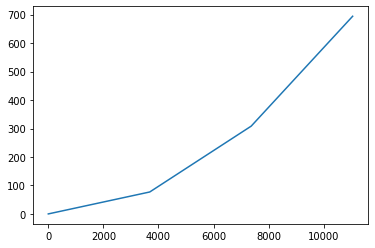

In [140]:
plt.plot(x0_, z0_)
plt.show()

In [141]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_
    elif j==9:    
        q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
    elif j==11:   
        q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)

In [142]:
q0

array([ 0.00000000e+00,  3.68422828e+03,  7.36845656e+03,  1.10526848e+04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  7.70680464e+01,  3.08407059e+02,  6.94421895e+02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        4.23898275e-01, -1.72800752e+00,  8.02455438e-01, -2.11085869e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        4.64486995e-02, -9.48990652e-01,  3.01441495e-01, -2.68390826e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [143]:
# q0[33]=q0[34]=q0[35]=q0[41]=q0[42]=q0[43]=1e-3

In [144]:
# q0

### Dynamics

In [145]:
# # def grayscott1d(Q,p,t):
# def grayscott1d(t, Q):
#     print(t)
     
#     x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]

#     x[0]=0
#     y[0]=0
#     z[0]=0

#     dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    
#     dx[0]=0
#     dy[0]=0
#     dz[0]=0

#     φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
#     Ret = Re_t(φ,θ,ψ)

#     dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
#     η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
#     dη=[dx[-1],dy[-1],dz[-1],dφ[-1],dθ[-1],dψ[-1]]
    
#     left=V.eq_left(η,dη)

#     # PD controller after 30 sec
# #     if t<30:
# #         ddη=np.linalg.lstsq(V.M, -left + tau(η, dη, wave_force, Fx_0/η[0], 0, t), rcond=None)[0]
# #     else:

#     hack =1
#     ddη=np.linalg.lstsq(V.M.astype(np.float32)*hack, -left.astype(np.float32) 
#                         + tau(η,dη, wave_coef, kp, kd, t).astype(np.float32)
#                         , rcond=None)[0]
# #     print('ddη', ddη)
 
#     tau_force = V.tau(η,dη,ddη).astype(np.float32)

#     C=ne(x,y,z,Ret)

  
#     a,b,c=C[:,0],C[:,1],C[:,2]
# #     Z0=tau_force[:3]
#     Z0=np.dot(Re_b(Ret),tau_force[:3])
   
#     Z1 = d_s(a,b,c,x,y,z).T

#     Z2=ne_(dx,dy,dz,DT,Ret).T
    
#     Z= ( np.einsum('ijk,ik->ij', Re_b(Ret), Z1 + Z2) + Z0)

     
# ############################################################    
# #     ddx,ddy, ddz = 1/Ws*np.linalg.solve(Re_b(Ret),Z).T 
# ############################################################    
#     ans_x=[]
#     ans_y=[]
#     ans_z=[]
#     RRRR=Re_b(Ret)
#     for i in range(len(RRRR)):
#         a,b,c=1/Ws*np.linalg.lstsq(RRRR[i],Z[i], rcond=None)[0]
#         ans_x.append(a)
#         ans_y.append(b)
#         ans_z.append(c)
    
#     ddx,ddy, ddz = np.array(ans_x),np.array(ans_y),np.array(ans_z)    
    
 
    
#     me_=me(φ,θ,ψ,x,y,z,Ret)

#     C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
#                                                         np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
#                                                                   np.array([dφ,dθ,dψ]).astype(np.float32).T))
    
#     C2= np.cross(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T),
#                  np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
#                            np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))

#     C3= d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T

#     C4= np.cross(d_s(x,y,z,x,y,z).T,ne(x,y,z,Ret))

#     K1=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T).T

#     C5= -np.dot(DR,K1).astype(np.float32).T

#     C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
#                         Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    
#     B_ =(-C1-C2+C3+C4+C5)
#     B=(np.einsum('ijk,ik->ij', Re_b(Ret), B_)
       
#        +C0.squeeze()
       
#       )

#     A2 = Irho_e(Ret).astype(np.float32)
#     A3=Π(φ,θ,ψ).astype(np.float32)

# #     A=np.einsum('ijk,ikr->ijr',A2,A3)
#     A=np.einsum('ijk,ikr->ijr', Re_b(Ret), np.einsum('ijk,ikr->ijr',A2,A3))

# ############################################
# #     ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
# #############################################

#     ans_φ=[]
#     ans_θ=[]
#     ans_ψ=[]
#     for i in range(len(A)):
#         a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
#         ans_φ.append(a)
#         ans_θ.append(b)
#         ans_ψ.append(c)
    
#     ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)

#     A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
# #     A1111=np.concatenate([dx, ddx, 
# #                           np.zeros(node_N), np.zeros(node_N),
# #                           dz, ddz,
# #                           np.zeros(node_N),  np.zeros(node_N),
# #                           np.zeros(node_N), np.zeros(node_N),
# #                           np.zeros(node_N),  np.zeros(node_N),
# #                           ], axis=0)

        

# #     print(A1111)
#     return A1111

In [146]:
# def grayscott1d(Q,p,t):
def grayscott1d(t, Q):
    print(t)
     
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]

#     x[0]=0
#     y[0]=0
#     z[0]=0

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    
#     dx[0]=0
#     dy[0]=0
#     dz[0]=0

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
    Ret = Re_t(φ,θ,ψ)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    dη=[dx[-1],dy[-1],dz[-1],dφ[-1],dθ[-1],dψ[-1]]
    
    left=V.eq_left(η,dη)

    # PD controller after 30 sec
#     if t<30:
#         ddη=np.linalg.lstsq(V.M, -left + tau(η, dη, wave_coef, Fx_0/η[0], 0, t), rcond=None)[0]
#     else:

    hack =1
    ddη=np.linalg.lstsq(V.M.astype(np.float32)*hack, -left.astype(np.float32) 
                        + tau(η,dη, wave_coef, kp, kd, t).astype(np.float32)
                        , rcond=None)[0]
#     print('ddη', ddη)
 
    tau_force = V.tau(η,dη,ddη).astype(np.float32)
#     tau_force = tau(η,dη, wave_coef, kp, kd, t) # simple motion 
#     print(tau_force)
#     C=ne(x,y,z,Ret)
#     a,b,c=C[:,0],C[:,1],C[:,2]
#     Z0=tau_force[:3]
#     Z0=tau_force[:3]

    Z0=np.dot(Re_b(Ret),tau_force[:3])
   
    Z1 =d_s(ne, x, y, z, Ret).T

    Z2=ne_(dx,dy,dz,DT,Ret).T
    
    Z= (Z1 + Z2 + Z0)

     
############################################################    
#     ddx,ddy, ddz = 1/Ws*np.linalg.solve(Re_b(Ret),Z).T 
############################################################    
    ans_x=[]
    ans_y=[]
    ans_z=[]
    RRRR=Re_b(Ret)
    for i in range(len(RRRR)):
        a,b,c=np.linalg.lstsq(Ws*RRRR[i], Z[i], rcond=None)[0]
        ans_x.append(a)
        ans_y.append(b)
        ans_z.append(c)
    
    ddx,ddy, ddz = np.array(ans_x),np.array(ans_y),np.array(ans_z) 
    
#     tmp=np.linalg.solve(Ret,np.vstack([ddx_phi, ddy_phi, ddz_phi]).T)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
    
    
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float32).T))
    
#     print(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T))
#     print(np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
#                            np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))
    C2= np.cross(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T),
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                           np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))

#     C3= d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T
    C3=d_me(φ,θ,ψ,Ret)
#     print(d_s(phi,x,y,z,Ret).T)
    C4= np.cross(d_s(phi,x,y,z,Ret).T, ne(x,y,z,Ret))

    K1=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T).T

    C5= -np.dot(DR,K1).astype(np.float32).T
#     print(np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)).shape)

#     C0=np.einsum('ijk,kp->ijp',
#                  np.linalg.inv(Π(φ,θ,ψ)), tau_force[3:].reshape(3,1)
#                 ) 
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
#     print(C1.shape,C2.shape,C3.shape,C4.shape,C5.shape)
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0.squeeze()
       

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)

    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     A=np.einsum('ijk,ikr->ijr', Re_b(Ret), np.einsum('ijk,ikr->ijr',A2,A3))

############################################
#     ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)
    
    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
    
    ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     A1111=np.concatenate([dx, ddx, 
#                           np.zeros(node_N), np.zeros(node_N),
#                           dz, ddz,
#                           np.zeros(node_N),  np.zeros(node_N),
#                           np.zeros(node_N), np.zeros(node_N),
#                           np.zeros(node_N),  np.zeros(node_N),
#                           ], axis=0)

        

#     print(A1111)
    return A1111

In [147]:
# ode15s = scipy.integrate.ode(grayscott1d)
# # ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# ode15s.set_integrator('vode',  order=15, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [148]:
# tspan = (0., 60)
tspan = (0., 5)

In [149]:
startTime1 = datetime.now()
# prob = de.ODEProblem(grayscott1d, q0, tspan)
# us = de.solve(prob)
us=solve_ivp(grayscott1d,  tspan, q0, 
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
# us=ode15s.integrate(10)
print(datetime.now() - startTime1)

0.0
9.403654815908773e-11
1.8807309631817545e-09
2.821096444772632e-09
7.522923852727018e-09
8.358804280807798e-09
9.403654815908773e-09
9.403654815908773e-09
2.526691610982901e-08
3.319854675678912e-08
7.285669999158972e-08
7.990703834444315e-08
8.871996128550995e-08
8.871996128550995e-08
2.3845321519014263e-07
3.1331984214245894e-07
6.876529769040407e-07
7.54201089750544e-07
8.373862308086733e-07
8.373862308086733e-07
1.83460195549205e-06
2.3332098178337382e-06
4.826249129542181e-06
5.269456118290348e-06
5.823464854225557e-06
5.823464854225557e-06
1.536449788795481e-05
2.0135014404819435e-05
4.3987596989142566e-05
4.822805611524445e-05
5.352863002287182e-05
5.352863002287182e-05
0.0001450325287630409
0.00019078447813312543
0.00041954422498354817
0.00046021262442362326
0.0005110481237237172
0.0005110481237237172
0.0007041922086774668
0.0008007642511543416
0.0012836244635387158
0.0013694662790737153
0.0014767685484924653
0.0014767685484924653
0.0006358242696106212
0.0006982123425540731

0.07371097666784326
0.074456202126829
0.07458868665287091
0.0747542923104233
0.0747542923104233
0.07505145722457071
0.07520003968164442
0.07594295196701294
0.07607502526218957
0.07624011688116035
0.07624011688116035
0.07651410030275183
0.07665109201354757
0.07733605056752628
0.07745782097712249
0.07761003398911775
0.07761003398911775
0.07786639519195672
0.07799457579337621
0.07863547880047363
0.0787494171128465
0.07889184000331259
0.07889184000331259
0.07915992736123557
0.07929397104019707
0.07996418943500454
0.0800833393718592
0.08023227679292752
0.08023227679292752
0.08053237607788806
0.08068242572036832
0.08143267393276966
0.08156605139275212
0.0817327732177302
0.0817327732177302
0.08204634730548088
0.08220313434935622
0.0829870695687329
0.08312643582995544
0.08330064365648358
0.08330064365648358
0.08358502905182041
0.08372722174948884
0.08443818523783092
0.08456457874686951
0.08472257063316775
0.08472257063316775
0.08354718970247493
0.0836704627254706
0.08428682784044897
0.08439640

0.16616230372729796
0.1663062149719632
0.1663062149719632
0.166561339102931
0.1666889011684149
0.16732671149583433
0.1674400999984867
0.16758183562680212
0.16758183562680212
0.1678663601504887
0.168008622412332
0.16871993372154845
0.16884638906540914
0.16900445824523502
0.16900445824523502
0.16932077051751
0.16947892665364744
0.17026970733433483
0.17041029056645704
0.1705860196066098
0.1705860196066098
0.17089149814738566
0.1710442374177736
0.17180793376971332
0.17194370201005815
0.17211341231048918
0.17211341231048918
0.17084529193647002
0.17097492810140014
0.1716231089260507
0.17173834107265526
0.17188238125591093
0.17188238125591093
0.17214165358577116
0.17227128975070127
0.17291947057535184
0.1730347027219564
0.17317874290521207
0.17317874290521207
0.17348175374071964
0.17363325915847344
0.17439078624724239
0.1745254577296902
0.17469379708274996
0.17469379708274996
0.17502120685314485
0.1751849117383423
0.17600343616432956
0.1761489516178384
0.17633084593472445
0.17633084593472445


0.25497239750664985
0.2551640686408651
0.2551640686408651
0.25374106784863115
0.2538920875564827
0.25464718609574055
0.25478142583605307
0.2549492255114437
0.2549492255114437
0.2552512649271469
0.2554022846349984
0.2561573831742563
0.2562916229145688
0.25645942258995946
0.25645942258995946
0.2567436447374001
0.2568857558111204
0.257596311179722
0.25772263213414004
0.2578805333271626
0.2578805333271626
0.2581389912312635
0.25826822018331397
0.2589143649435663
0.25902923512316667
0.2591728228476672
0.2591728228476672
0.2594302285685922
0.25955893142905473
0.2602024457313673
0.26031684827400065
0.26045985145229233
0.26045985145229233
0.2607468972555225
0.2608904201571376
0.261608034665213
0.26173561057775974
0.2618950804684432
0.2618950804684432
0.26221039588619083
0.26236805359506465
0.26315634213943384
0.26329648232509945
0.2634716575571815
0.2634716575571815
0.26377279965103406
0.26392337069796035
0.2646762259325918
0.26481006686319297
0.2649773680264444
0.2649773680264444
0.2637284752

0.3453066184143014
0.346139776560185
0.34628789356389766
0.34647303981853844
0.34647303981853844
0.3451054720397141
0.3452548462961855
0.3460017175785427
0.3461344946954062
0.34630046609148557
0.34630046609148557
0.34659921460442844
0.3467485888608999
0.34749546014325705
0.34762823726012054
0.3477942086561999
0.3477942086561999
0.34807718538714194
0.34821867375261295
0.348926115579968
0.34905188301594225
0.34920909231091
0.34920909231091
0.3494699726878217
0.3496004128762775
0.3502526138185567
0.3503685606527397
0.3505134941954684
0.3505134941954684
0.35077412636440347
0.350904442448871
0.3515560228712087
0.35167185939073536
0.35181665504014376
0.35181665504014376
0.35210340431543447
0.3522467789530799
0.3529636521413067
0.35309109626365814
0.3532504014165974
0.3532504014165974
0.3535609704678366
0.35371625499345616
0.3544926776215541
0.35463070831099375
0.3548032466727933
0.3548032466727933
0.3551006184895728
0.3552493043979626
0.3559927339399115
0.3561248991918135
0.356290105756691
0

0.43590997670602444
0.43607748122495826
0.43607748122495826
0.43641275657387263
0.4365803942483298
0.4374185826206156
0.4375675938867998
0.43775385796953
0.43775385796953
0.4363754259978466
0.4365243983842908
0.43726926031651175
0.43740168021557324
0.4375672050894001
0.4375672050894001
0.43786514986228847
0.43801412224873265
0.4387589841809536
0.4388914040800151
0.43905692895384196
0.43905692895384196
0.43934069070314713
0.43948257157779974
0.44019197595106274
0.44031809228408725
0.4404757377003679
0.4404757377003679
0.4407378758860648
0.44086894497891327
0.4415242904431555
0.4416407963034652
0.44178642862885237
0.44178642862885237
0.44204695094362945
0.442177212101018
0.4428285178879607
0.4429443055834172
0.44308904020273776
0.44308904020273776
0.4433738614075582
0.4435162720099684
0.4442283250220195
0.4443549122241619
0.4445131462268399
0.4445131462268399
0.44482182594057484
0.44497616579744226
0.44574786508177955
0.44588505606566176
0.4460565447955145
0.4460565447955145
0.4463545035

0.5216834765144301
0.5216834765144301
0.5219838465341812
0.5221340315440566
0.522884956593434
0.5230184543799901
0.5231853266131851
0.5231853266131851
0.5234991774509581
0.5236561028698447
0.5244407299642773
0.5245802192255097
0.5247545808020503
0.5247545808020503
0.5250372939788768
0.5251786505672901
0.5258854335093565
0.5260110838101683
0.526168146686183
0.526168146686183
0.5249981442850806
0.5251199260265957
0.5257288347341716
0.525837085171074
0.525972398217202
0.525972398217202
0.5262159617002323
0.5263377434417476
0.5269466521493233
0.5270549025862257
0.5271902156323537
0.5271902156323537
0.5274950784898006
0.527647509918524
0.5284096670621412
0.528545161665451
0.5287145299195881
0.5287145299195881
0.5290635790564556
0.5292381036248893
0.5301107264670579
0.5302658594167768
0.5304597756039254
0.5304597756039254
0.5290182181998236
0.5291700623399415
0.5299292830405304
0.530064255609524
0.530232971320766
0.530232971320766
0.5305366596010015
0.5306885037411193
0.5314477244417083
0.53

0.6183305754673694
0.6183305754673694
0.6186334668277532
0.6187849125079452
0.619542140908905
0.6196767592912978
0.6198450322692889
0.6198450322692889
0.6201898126156107
0.6203622027887716
0.6212241536545761
0.6213773893640524
0.6215689340008979
0.6215689340008979
0.6201477040124288
0.6202990398839988
0.6210557192418488
0.6211902400165776
0.6213583909849887
0.6213583909849887
0.6216610627281286
0.6218123985996986
0.6225690779575486
0.6227035987322774
0.6228717497006885
0.6228717497006885
0.6231542220436951
0.6232954582151984
0.624001639072715
0.6241271823362735
0.6242841114157216
0.6242841114157216
0.6245393251706836
0.6246669320481646
0.6253049664355694
0.625418394771108
0.6255601801905314
0.6255601801905314
0.6258156794740795
0.6259434291158534
0.6265821773247235
0.6266957325618561
0.6268376766082716
0.6268376766082716
0.6271258028297296
0.6272698659404586
0.6279901814941037
0.6281182375925295
0.6282783077155617
0.6282783077155617
0.6285958686157417
0.6287546490658317
0.6295485513162

0.7057912431183229
0.7064323643804032
0.706546341493662
0.7066888128852354
0.7066888128852354
0.706991071964393
0.7071422015039718
0.7078978492018657
0.7080321865703803
0.7082001082810233
0.7082001082810233
0.7085288042858469
0.7086931522882586
0.7095148923003174
0.7096609794135723
0.7098435883051409
0.7098435883051409
0.7084912254361961
0.7086367840137825
0.7093645769017145
0.7094939623040135
0.7096556940568873
0.7096556940568873
0.7099468112120602
0.7100923697896465
0.7108201626775785
0.7109495480798775
0.7111112798327514
0.7111112798327514
0.7113970254295022
0.7115398982278776
0.7122542622197546
0.7123812602627551
0.7125400078165055
0.7125400078165055
0.7128107646480718
0.712946143063855
0.7136230351427708
0.7137433715123558
0.7138937919743371
0.7138937919743371
0.7141584403293251
0.7142907645068192
0.7149523853942892
0.7150700068853949
0.7152170337492771
0.7152170337492771
0.7154942068248256
0.7156327933625998
0.7163257260514708
0.7164489140850478
0.7166028991270192
0.7166028991270

0.7924802010686123
0.7926310113684372
0.7933850628675615
0.7935191164674058
0.7936866834672113
0.7936866834672113
0.7940121613643367
0.7941749003128995
0.7949885950557132
0.7951332518988801
0.7953140729528386
0.7953140729528386
0.7939758427166176
0.7941204223413206
0.7948433204648363
0.7949718356867946
0.7951324797142426
0.7951324797142426
0.7954216389636489
0.795566218588352
0.7962891167118676
0.796417631933826
0.796578275961274
0.796578275961274
0.7968641848959002
0.7970071393632133
0.797721911699779
0.7978489823373907
0.7980078206344052
0.7980078206344052
0.7982807460505145
0.7984172087585691
0.7990995222988424
0.7992208224837798
0.7993724477149516
0.7993724477149516
0.7996384517687489
0.7997714537956475
0.8004364639301406
0.8005546879540505
0.8007024679839378
0.8007024679839378
0.8009779561196536
0.8011157001875115
0.8018044205268011
0.8019268596982303
0.8020799086625169
0.8020799086625169
0.8023721787118314
0.8025183137364886
0.803248988859775
0.8033788866594703
0.8035412589090896

0.8834778967331477
0.8822393480153683
0.882367091353681
0.8830058080452445
0.8831193576793003
0.88326129472187
0.88326129472187
0.8835167813984954
0.8836445247368081
0.8842832414283717
0.8843967910624274
0.8845387281049971
0.8845387281049971
0.884839904781632
0.8849904931199495
0.8857434348115366
0.8858772911122632
0.8860446114881715
0.8860446114881715
0.8863730275627768
0.8865372356000795
0.8873582757865928
0.8875042384864174
0.8876866918611981
0.8876866918611981
0.8863362194725452
0.8864820234647319
0.8872110434256659
0.8873406469742765
0.8875026514100396
0.8875026514100396
0.8877942593944133
0.8879400633866
0.888669083347534
0.8887986868961446
0.8889606913319077
0.8889606913319077
0.8892454130131109
0.8893877738537126
0.8900995780567207
0.8902261210261443
0.8903842997379239
0.8903842997379239
0.8906530790638589
0.8907874687268266
0.8914594170416643
0.8915788745198576
0.8917281963675994
0.8917281963675994
0.891991824396782
0.8921236384113734
0.8927827084843302
0.8928998764973002
0.89

0.9772697547455629
0.9774107547511126
0.9781157547788615
0.978241088117128
0.978397754789961
0.978397754789961
0.9786579827577907
0.9787880967417055
0.9794386666612797
0.9795543235358706
0.9796988946291093
0.9796988946291093
0.9799581624853201
0.9800877964134255
0.9807359660539525
0.9808511962122685
0.9809952339101633
0.9809952339101633
0.9812795720890043
0.9814217411784247
0.982132586625527
0.9822589591494564
0.982416924804368
0.982416924804368
0.9827250212532852
0.9828790694777438
0.9836493106000369
0.9837862423551111
0.9839574070489541
0.9839574070489541
0.9842536506068044
0.9844017723857295
0.985142381280355
0.9852740450838441
0.9854386248382053
0.9854386248382053
0.9842161885468865
0.9843455792958528
0.9849925330406838
0.9851075470397649
0.9852513145386163
0.9852513145386163
0.9855100960365487
0.9856394867855149
0.986286440530346
0.9864014545294271
0.9865452220282784
0.9865452220282784
0.9868429632216646
0.9869918338183578
0.9877361868018232
0.9878685162211059
0.9880339279952094
0

1.0636187971169258
1.0636187971169258
1.063919668366096
1.0640701039906812
1.0648222821136073
1.064956002668794
1.0651231533627776
1.0651231533627776
1.0654066349825715
1.0655483757924686
1.0662570798419535
1.066383071672973
1.0665405614617474
1.0665405614617474
1.0667972083749901
1.0669255318316118
1.067567149114719
1.0676812144094934
1.0678237960279617
1.0678237960279617
1.0680780377425594
1.0682051585998584
1.0688407628863528
1.0689537592039517
1.0690950046009504
1.0690950046009504
1.0693788483871505
1.0695207702802505
1.0702303797457504
1.0703565325396172
1.0705142235319505
1.0705142235319505
1.07082810279844
1.070985042431685
1.071769740597909
1.0719092424941266
1.0720836198643986
1.0720836198643986
1.0723848472062008
1.0725354608771018
1.0732885292316074
1.0734224080501862
1.0735897565734096
1.0735897565734096
1.0723395056681755
1.072467448570064
1.0731071630795064
1.0732208901034073
1.0733630488832833
1.0733630488832833
1.0736189346870602
1.0737468775889487
1.074386592098391
1.0

1.1612916530084725
1.161441105816211
1.161441105816211
1.1616899004981611
1.1618142978391364
1.1624362845440117
1.1625468599582116
1.1626850792259618
1.1626850792259618
1.162948871323173
1.1630807673717787
1.1637402476148067
1.1638574885469006
1.164004039712018
1.164004039712018
1.1643061526421878
1.1644572091072727
1.1652124914326973
1.1653467638461061
1.1655146043628672
1.1655146043628672
1.1658317889336
1.1659903812189667
1.166783342645799
1.1669243135661247
1.1671005272165318
1.1671005272165318
1.165795628974383
1.1659361412801406
1.1666387028089296
1.16676360263627
1.1669197274204453
1.1669197274204453
1.167200752031961
1.1673412643377186
1.1680438258665076
1.168168725693848
1.1683248504780233
1.1683248504780233
1.1686127906786277
1.1687567607789298
1.1694766112804404
1.1696045847029313
1.1697645514810449
1.1697645514810449
1.1700477247931502
1.170189311449203
1.1708972447294668
1.171023099534847
1.1711804180415721
1.1711804180415721
1.1714513401261446
1.1715868011684307
1.1722641

1.2505714875913265
1.2507364147587943
1.2507364147587943
1.2510045160246088
1.251138566657516
1.2518088198220523
1.251927975940192
1.2520769210878668
1.2520769210878668
1.252325131358049
1.25244923649314
1.2530697621685956
1.2531800778442321
1.2533179724387777
1.2533179724387777
1.2535820426252675
1.2537140777185125
1.2543742531847368
1.2544916177120655
1.2546383233712266
1.2546383233712266
1.2549411363918226
1.2550925429021205
1.25584957545361
1.2559841590183194
1.256152388474206
1.256152388474206
1.2564695055467878
1.2566280640830787
1.2574208567645333
1.2575617976856808
1.257737973837115
1.257737973837115
1.2564322281901175
1.256572148048073
1.2572717473378512
1.257396120544923
1.2575515870537626
1.2575515870537626
1.257831426769674
1.2579713466276294
1.2586709459174077
1.2587953191244794
1.258950785633319
1.258950785633319
1.259239239788081
1.2593834668654618
1.2601046022523663
1.2602328040989272
1.2603930564071282
1.2603930564071282
1.2606778221247696
1.2608202049835902
1.26153211

1.3454753739042118
1.3457736837633705
1.3459228386929496
1.346668613340846
1.3468011955004722
1.3469669232000048
1.3469669232000048
1.3457297793508622
1.3458569820741875
1.3464929956908134
1.3466060647782137
1.3467474011374638
1.3467474011374638
1.3470018065841143
1.3471290093074395
1.3477650229240654
1.3478780920114657
1.3480194283707159
1.3480194283707159
1.348319707732163
1.3484698474128864
1.349220545816504
1.3493540033104805
1.3495208251779511
1.3495208251779511
1.3498483217700883
1.3500120700661566
1.3508308115464993
1.3509763655874492
1.3511583081386365
1.3511583081386365
1.3498112298841574
1.3499564322372604
1.3506824440027758
1.3508115127610898
1.350972848708982
1.350972848708982
1.3512632534151883
1.3514084557682913
1.3521344675338067
1.3522635362921207
1.352424872240013
1.352424872240013
1.3527086225153109
1.3528504976529598
1.3535598733412046
1.3536859845746705
1.3538436236165026
1.3538436236165026
1.3541115431491781
1.3542455029155158
1.3549153017472046
1.3550343770950606


1.4365453103220571
1.4372621877712008
1.4373896326510485
1.4375489387508582
1.4375489387508582
1.4363587747798394
1.4364805702434738
1.437089547561645
1.4371978101959866
1.4373331384889134
1.4373331384889134
1.4375767294161819
1.4376985248798162
1.4383075021979874
1.438415764832329
1.4385510931252559
1.4385510931252559
1.4388545280292524
1.4390062454812507
1.4397648327412418
1.4398996926985737
1.4400682676452383
1.4400682676452383
1.4404129112709678
1.4405852330838325
1.441446842148156
1.4416000170929248
1.4417914857738856
1.4417914857738856
1.4403672230111144
1.4405167006940525
1.441264089108743
1.4413969581602435
1.441563044474619
1.441563044474619
1.4418619998404951
1.4420114775234332
1.4427588659381236
1.4428917349896242
1.4430578213039997
1.4430578213039997
1.4433400986201559
1.443481237278234
1.4441869305686241
1.4443123871535823
1.4444692078847803
1.4444692078847803
1.4447258693601548
1.4448542000978422
1.4454958537862783
1.4456099255531114
1.4457525152616528
1.4457525152616528


1.530736278685506
1.5308791936058534
1.5315937682075906
1.531720803692344
1.5318795980482856
1.5318795980482856
1.532195034178024
1.5323527522428932
1.5331413425672393
1.5332815364026786
1.5334567786969777
1.5334567786969777
1.5337551428992913
1.5339043250004483
1.5346502355062324
1.5347828418183718
1.534948599708546
1.534948599708546
1.5337073923498488
1.5338326991762843
1.5344592333084621
1.5345706171541826
1.5347098469613332
1.5347098469613332
1.5349604606142042
1.5350857674406397
1.5357123015728176
1.535823685418538
1.5359629152256886
1.5359629152256886
1.536265236422986
1.536416397021635
1.5371722000148786
1.5373065649914552
1.537474521212176
1.537474521212176
1.537808337091274
1.537975245030823
1.538809784728568
1.5389581473415004
1.539143600607666
1.539143600607666
1.5377665072044913
1.5379125002006486
1.5386424651814363
1.5387722367335765
1.5389344511737515
1.5389344511737515
1.5392264371660667
1.539372430162224
1.5401023951430117
1.540232166695152
1.540394381135327
1.540394381

1.6268559600755772
1.6275927357903683
1.6277237181396647
1.6278874460762849
1.6278874460762849
1.6281975351870093
1.6283525797423715
1.6291278025191827
1.6292656199017268
1.629437891629907
1.629437891629907
1.6297207601042858
1.629862194341475
1.630569365527422
1.6306950848493682
1.6308522340018008
1.6308522340018008
1.6296822370942525
1.6298044098264255
1.6304152734872894
1.630523871471443
1.630659618951635
1.630659618951635
1.6309039644159804
1.6310261371481534
1.6316370008090173
1.6317455987931708
1.6318813462733628
1.6318813462733628
1.6321823740954364
1.6323328880064734
1.6330854575616578
1.6332192477048015
1.6333864853837314
1.6333864853837314
1.6337272671212553
1.633897657990017
1.6347496123338263
1.634901070883837
1.6350903940713502
1.6350903940713502
1.633684896966036
1.633834102757188
1.6345801317129494
1.6347127590828625
1.634878543295254
1.634878543295254
1.6351769548775585
1.6353261606687106
1.6360721896244719
1.636204816994385
1.6363706012067765
1.6363706012067765
1.63665

1.719996247630822
1.7201363332448265
1.7208367613148492
1.720961281860631
1.7211169325428584
1.7211169325428584
1.7199657001095663
1.7200905119629433
1.7207145712298273
1.7208255150994956
1.7209641949365808
1.7209641949365808
1.7212138186433343
1.7213386304967113
1.7219626897635953
1.7220736336332636
1.7222123134703489
1.7222123134703489
1.7225087111860868
1.722656910043956
1.723397904333301
1.7235296366514068
1.723694302049039
1.723694302049039
1.7240234714923008
1.7241880562139316
1.725010979822086
1.7251572773524246
1.725340149265348
1.725340149265348
1.7239894402562088
1.7241370093597936
1.7248748548777182
1.7250060274142383
1.725169993084888
1.725169993084888
1.725465131292058
1.7256127003956427
1.7263505459135673
1.7264817184500874
1.7266456841207372
1.7266456841207372
1.7269254091612471
1.727065271681502
1.727764584282777
1.7278889065230036
1.728044309323287
1.728044309323287
1.728302358296813
1.728431382783576
1.7290765052173913
1.7291911936500695
1.7293345541909173
1.729334554

1.8075979143124734
1.8077411452318901
1.8084572998289739
1.808584616201789
1.8087437616678075
1.8087437616678075
1.8075524581396905
1.8076729609727156
1.808275475137842
1.808382588767198
1.8085164808038927
1.8085164808038927
1.8087574864699434
1.8088779893029685
1.809480503468095
1.809587617097451
1.8097215091341456
1.8097215091341456
1.8100253847259251
1.8101773225218147
1.8109370115012633
1.811072067319832
1.8112408870930428
1.8112408870930428
1.8115882238575
1.8117618922397287
1.8126302341508718
1.812784606046186
1.812977570915329
1.812977570915329
1.8115399431638262
1.811689471199218
1.8124371113761766
1.8125700251854135
1.81273616744696
1.81273616744696
1.8130352235177434
1.8131847515531352
1.8139323917300938
1.8140653055393308
1.8142314478008772
1.8142314478008772
1.8145131378510777
1.814653982876178
1.8153582080016792
1.8154834035795462
1.8156398980518798
1.8156398980518798
1.8158948379230462
1.8160223078586295
1.8166596575365455
1.8167729641459527
1.8169145974077119
1.816914597

1.8999416244489507
1.9000817458088886
1.9000817458088886
1.900336338588555
1.900463634978388
1.901100116927554
1.9012132692740726
1.9013547097072205
1.9013547097072205
1.9016417721250485
1.9017853033339625
1.9025029593785323
1.9026305426753447
1.9027900217963603
1.9027900217963603
1.9031036183623251
1.9032604166453075
1.90404440806022
1.9041837843117597
1.9043580046261848
1.9043580046261848
1.9046520930007598
1.9047991371880473
1.9055343581244848
1.9056650640687403
1.9058284464990598
1.9058284464990598
1.9046062584668066
1.9047303853871178
1.9053510199886727
1.905461355028949
1.9055992738292946
1.9055992738292946
1.9058475276699165
1.9059716545902277
1.9065922891917826
1.9067026242320588
1.9068405430324045
1.9068405430324045
1.9071419020415241
1.907292581546084
1.908045979068883
1.9081799164062696
1.9083473380780027
1.9083473380780027
1.9086822449745127
1.9088496984227679
1.909686965664043
1.9098358131736028
1.910021872560553
1.910021872560553
1.908640026234454
1.90878637031268
1.90951

1.9864813950221287
1.986609259390944
1.987248581235019
1.9873622384517433
1.9875043099726488
1.9875043099726488
1.9877669371618112
1.9878982507563925
1.9885548187292985
1.9886715419244818
1.9888174459184609
1.9888174459184609
1.989107277630147
1.9892521934859901
1.9899767727652053
1.990105586859288
1.9902666044768915
1.9902666044768915
1.9905718714359433
1.990724504915469
1.991487672313098
1.9916233465171211
1.9917929392721498
1.9917929392721498
1.9920767325921338
1.9922186292521256
1.9929281125520852
1.9930542429165226
1.9932119058720692
1.9932119058720692
1.992042123607284
1.9921667157748513
1.9927896766126871
1.99290042520608
1.9930388609478213
1.9930388609478213
1.9932880452829556
1.9934126374505228
1.9940355982883586
1.9941463468817515
1.9942847826234928
1.9942847826234928
1.9945818241933804
1.994730344978324
1.9954729489030427
1.9956049673785483
1.9957699904729302
1.9957699904729302
1.9960994270317156
1.9962641453111083
1.9970877367080717
1.9972341529564208
1.997417173266857
1.99

2.0753141969901523
2.076045752132833
2.0761758063804208
2.0763383741899055
2.0763383741899055
2.076606753226513
2.076740942744817
2.0774118903363354
2.077531169908161
2.077680269372943
2.077680269372943
2.0779309260578582
2.078056254400316
2.0786828961126043
2.0787942990836776
2.0789335527975195
2.0789335527975195
2.0791970154948998
2.0793287468435904
2.0799874035870416
2.0801044981192107
2.080250866284422
2.080250866284422
2.0805475062457885
2.080695826226472
2.0814374261298894
2.081569266112719
2.081734066091256
2.081734066091256
2.082043848302334
2.0821987394078727
2.0829731949355677
2.083110875918269
2.0832829771466455
2.0832829771466455
2.0835617979096384
2.0837012082911346
2.0843982601986166
2.0845221805377245
2.0846770809616095
2.0846770809616095
2.083523178213948
2.0836432787475996
2.0842437814158568
2.084350537445769
2.0844839824831594
2.0844839824831594
2.084724183550462
2.0848442840841135
2.0854447867523707
2.085551542782283
2.0856849878196733
2.0856849878196733
2.0859859236

2.162437173837027
2.1631402427721054
2.163265232805008
2.1634214703461367
2.1634214703461367
2.163730992402876
2.163885753431246
2.164659558573094
2.1647971239316446
2.164969080629833
2.164969080629833
2.1652663904441694
2.1654150453513377
2.1661583198871783
2.1662904575824387
2.1664556297015145
2.1664556297015145
2.1652233859756773
2.165350538648599
2.1659863020132093
2.1660993266113624
2.1662406073590534
2.1662406073590534
2.1664949127048976
2.1666220653778194
2.1672578287424296
2.1673708533405827
2.1675121340882737
2.1675121340882737
2.16780955384023
2.1679582637162085
2.1687018130960998
2.168833999652525
2.1689992328480563
2.1689992328480563
2.169321561835601
2.1694827263293734
2.170288548798235
2.170431806126033
2.17061087778578
2.17061087778578
2.1692864108898404
2.169429999910733
2.1701479450151937
2.170275579700431
2.170435123056978
2.170435123056978
2.170722301098762
2.1708658901196545
2.1715838352241152
2.1717114699093525
2.1718710132658994
2.1718710132658994
2.17215285503906

2.255109538521883
2.2552506155823857
2.255956000884897
2.2560814027164544
2.256238155005901
2.256238155005901
2.256502009151844
2.256633936224816
2.257293571589673
2.2574108400989807
2.257557425735616
2.257557425735616
2.2578156943285412
2.257944828625004
2.2585905001073168
2.2587052861486168
2.258848768700242
2.258848768700242
2.2591238621949716
2.2592614089423364
2.2599491426791602
2.2600714064545957
2.26022423617389
2.26022423617389
2.2605212294398433
2.26066972607282
2.261412209237704
2.2615442062447944
2.2617092025036576
2.2617092025036576
2.262003701381094
2.2621509508198123
2.262887198013404
2.2630180864033758
2.2631816968908405
2.2631816968908405
2.2634476635879097
2.2635806469364446
2.264245563679118
2.2643637711000375
2.264511530376187
2.264511530376187
2.264757589966523
2.264880619761691
2.2654957687375306
2.2656051285554577
2.2657418283278665
2.2657418283278665
2.2660034514420215
2.266134262999099
2.2667883207844866
2.266904597724111
2.2670499438986416
2.2670499438986416
2.

2.3472653462873883
2.3472653462873883
2.3476044019923235
2.3477739298447915
2.34862156910713
2.3487722605315455
2.348960624812065
2.348960624812065
2.347562056392878
2.3477104114456226
2.3484521867093466
2.348584057867342
2.3487488968148362
2.3487488968148362
2.349045606920326
2.3491939619730706
2.3499357372367946
2.35006760839479
2.350232447342284
2.350232447342284
2.3505117526905797
2.3506514053647276
2.351349668735467
2.3514738044458205
2.3516289740837624
2.3516289740837624
2.3518830037334943
2.3520100185583606
2.352645092682691
2.3527579947492385
2.352899122332423
2.352899122332423
2.35315204576531
2.3532785074817535
2.353910816063971
2.354023226478587
2.3541637394968578
2.3541637394968578
2.354445667380859
2.3545866313228596
2.355291451032863
2.355416752314641
2.3555733789168642
2.3555733789168642
2.355883064601274
2.356037907443479
2.356812121654504
2.3569497597364637
2.3571218073389137
2.3571218073389137
2.3574177105617466
2.3575656621731627
2.3583054202302445
2.358436932773726


2.4457887544774644
2.4465510824323773
2.4466866074021394
2.4468560136143425
2.4468560136143425
2.4471480566190773
2.4472940781214447
2.4480241856332814
2.448153982524275
2.4483162286380162
2.4483162286380162
2.4471105254292898
2.4472377813367636
2.4478740608741316
2.4479871772363304
2.448128572689079
2.448128572689079
2.448383084504026
2.4485103404114996
2.449146619948868
2.449259736311067
2.4494011317638154
2.4494011317638154
2.4496958178821706
2.4498431609413482
2.450579876237237
2.4507108478453947
2.450874562355592
2.450874562355592
2.4511932685479416
2.451352621644116
2.4521493871249893
2.4522910343215893
2.452468093317339
2.452468093317339
2.451161349873873
2.451304743633013
2.4520217124287145
2.4521491735479506
2.4523084999469953
2.4523084999469953
2.452595287465276
2.452738681224416
2.4534556500201177
2.453583111139354
2.4537424375383985
2.4537424375383985
2.4540226156644764
2.454162704727515
2.45486315004271
2.4549876736543
2.4551433281687878
2.4551433281687878
2.45540911036217

2.5365157976066994
2.5368085481007405
2.5369549233477606
2.537686799582863
2.537816910913548
2.537979550076904
2.537979550076904
2.536772681153921
2.536901122927531
2.5375433317955842
2.537657502261016
2.5378002153428056
2.5378002153428056
2.538057098890027
2.5381855406636373
2.5388277495316904
2.5389419199971224
2.539084633078912
2.539084633078912
2.5393776131612467
2.539524103202414
2.5402565534082506
2.540386766778177
2.5405495334905854
2.5405495334905854
2.5408632740409214
2.5410201443160894
2.541804495691929
2.541943935936523
2.5421182362422647
2.5421182362422647
2.542402995327069
2.542545374869471
2.543257272581481
2.5433838321747273
2.543542031666285
2.543542031666285
2.5423574119668033
2.5424769998290726
2.5430749391404195
2.5431812394624367
2.543314114864958
2.543314114864958
2.5435532905894966
2.543672878451766
2.544270817763113
2.54437711808513
2.5445099934876514
2.5445099934876514
2.5448122599984955
2.544963393253917
2.545719059531027
2.545853400202513
2.546021326041871
2.5

2.6271665087762415
2.627281203727712
2.6274245724170506
2.6274245724170506
2.6276915805694734
2.6278250846456843
2.6284926050267408
2.6286112753167066
2.6287596131791635
2.6287596131791635
2.6290484998463253
2.629192943179906
2.62991515984781
2.6300435539221043
2.630204046514972
2.630204046514972
2.6305007641404456
2.6306491229531823
2.631390917016866
2.6315227915170767
2.63168763464234
2.63168763464234
2.631963699005553
2.6321017311871597
2.6327918920951925
2.6329145873677313
2.6330679564584054
2.6330679564584054
2.6333185449799634
2.633443839240742
2.6340703105446366
2.6341816832208846
2.6343208990661946
2.6343208990661946
2.634573741017313
2.6347001619928725
2.6353322668706687
2.6354446410711656
2.635585108821787
2.635585108821787
2.6358703389154465
2.636012953962276
2.6367260291964243
2.63685279812694
2.637011259290084
2.637011259290084
2.637323124465196
2.6374790570527518
2.638258719990532
2.638397326735026
2.638570585165644
2.638570585165644
2.638863115378824
2.639009380485414
2.

2.712753846706816
2.7128730532992797
2.71302206153986
2.71302206153986
2.713283844758371
2.7134147363676266
2.714069194413905
2.7141855425110206
2.714330977632416
2.714330977632416
2.714602519963861
2.7147382911295836
2.7154171469581967
2.715537832438839
2.715688689289642
2.715688689289642
2.7159766624501445
2.7161206490303953
2.7168405819316512
2.7169685700029858
2.717128555092154
2.717128555092154
2.7174184788995546
2.7175634408032554
2.718288250321758
2.718417105347269
2.7185781741291586
2.7185781741291586
2.7188496222622227
2.7189853463287545
2.719663966661414
2.7197846102761094
2.7199354147944783
2.7199354147944783
2.7201896587101415
2.720316780667973
2.7209523904571307
2.721065387752981
2.721206634372794
2.721206634372794
2.721467749229129
2.721598306657296
2.7222510937981337
2.7223671448453937
2.722512208654469
2.722512208654469
2.7228002562064417
2.722944279982428
2.7236643988623594
2.7237924199965695
2.7239524464143323
2.7239524464143323
2.7242557160190954
2.7244073508214766
2

2.7997581132972016
2.8000449778825987
2.800188410175297
2.80090557163879
2.8010330670100774
2.801192436224187
2.801192436224187
2.801472713145976
2.801612851606871
2.8023135439113442
2.8024381114321395
2.8025938208331334
2.8025938208331334
2.8028585130731773
2.8029908591931996
2.80365258979331
2.803770230788885
2.8039172820333538
2.8039172820333538
2.8041767781281193
2.804306526175502
2.8049552664124158
2.805070598010089
2.8052147625071813
2.8052147625071813
2.8054882661347467
2.8056250179485294
2.8063087770174424
2.8064303341852495
2.806582280645008
2.806582280645008
2.806874580381044
2.8070207302490626
2.807751479589154
2.807881390582948
2.8080437793251902
2.8080437793251902
2.8083345793018353
2.8084799792901576
2.8092069792317695
2.809336223665834
2.8094977792084146
2.8094977792084146
2.8097645549529036
2.809897942825148
2.810564882186371
2.8106834491839217
2.81083165793086
2.81083165793086
2.811080853609159
2.8112054514483082
2.811828440644056
2.811939194278856
2.812077636322355
2.

2.8937712752609777
2.8944004592671884
2.894512314201626
2.8946521328696724
2.8946521328696724
2.894931625735846
2.8950713721689327
2.895770104334367
2.895894323386
2.8960495972005407
2.8960495972005407
2.8963569929222786
2.8965106907831473
2.8972791800874917
2.897415800408264
2.8975865758092296
2.8975865758092296
2.897881898744941
2.898029560212797
2.898767867552076
2.8988991221901697
2.8990631904877873
2.8990631904877873
2.8978394649467973
2.8979659095155816
2.8985981323595014
2.8987105275317537
2.898851021497069
2.898851021497069
2.899103910634637
2.899230355203421
2.899862578047341
2.899974973219593
2.9001154671849085
2.9001154671849085
2.900410923337756
2.90055865141418
2.901297291796299
2.901428605642009
2.9015927479491466
2.9015927479491466
2.9019128113104764
2.9020728429911413
2.9028730013944664
2.9030152517772794
2.903193064755796
2.903193064755796
2.901878133111472
2.9020208256926345
2.9027342885984484
2.902861126448371
2.903019673760774
2.903019673760774
2.9033050589230993
2.

2.9851663321778883
2.9852944934410113
2.9854546950199152
2.9854546950199152
2.985743057861942
2.985887239282955
2.986608146388022
2.986736307651145
2.986896509230049
2.986896509230049
2.987177019822676
2.98731727511899
2.9880185516005575
2.9881432229750584
2.9882990621931844
2.9882990621931844
2.988561628582251
2.9886929117767838
2.9893493277494496
2.9894660239223683
2.989611894138516
2.989611894138516
2.9898687716224153
2.989997210364365
2.990639404074113
2.990753571844735
2.9908962815580122
2.9908962815580122
2.99116947571706
2.9913060727965837
2.991989058194203
2.9921104778204466
2.992262252353251
2.992262252353251
2.992557008089355
2.992704385957407
2.993441275297667
2.9935722778470466
2.9937360310337713
2.9937360310337713
2.9940286607487034
2.9941749756061697
2.9949065498935004
2.995036607544581
2.9951991796084325
2.9951991796084325
2.9954639648065102
2.995596357405549
2.996258320400744
2.9963760027110005
2.9965231055988215
2.9965231055988215
2.9967681084846887
2.9968906099276227


3.0721057620634578
3.0723860980817217
3.0725262660908537
3.073227106136513
3.073351699922408
3.073507442154777
3.073507442154777
3.073774837006283
3.0739085344320363
3.0745770215608017
3.0746958637170265
3.074844416412308
3.074844416412308
3.0751052822926477
3.0752357152328176
3.0758878799336675
3.07600382032493
3.0761487458140073
3.0761487458140073
3.076419373592152
3.076554687481224
3.077231256926585
3.0773515359390937
3.0775018847047297
3.0775018847047297
3.0777890824670795
3.077932681348255
3.0786506757541297
3.078778319204063
3.0789378735164794
3.0789378735164794
3.0792271256803025
3.079371751762214
3.080094882171771
3.0802234386890257
3.080384134335594
3.080384134335594
3.0806548204425996
3.080790163496103
3.081466878763617
3.0815871837000635
3.0817375648706222
3.0817375648706222
3.081990859367087
3.0821175066153197
3.0827507428564815
3.082863318188244
3.0830040373529464
3.0830040373529464
3.0832641420116613
3.083394194341019
3.0840444559878066
3.0841600580583464
3.08430456064652

3.1598901119543483
3.160212629037115
3.160373887578498
3.1611801802854145
3.1613235212110884
3.161502697368181
3.161502697368181
3.16017618137214
3.160319216081035
3.1610343896255135
3.1611615315889767
3.161320459043305
3.161320459043305
3.1616065284610966
3.161749563169992
3.1624647367144703
3.1625918786779335
3.162750806132262
3.162750806132262
3.163030271605546
3.1631700043421884
3.1638686680253993
3.1639928749024144
3.1641481334986836
3.1641481334986836
3.16441197741385
3.1645438993714334
3.1652035091593493
3.1653207731216457
3.165467353074516
3.165467353074516
3.165725987543059
3.165855304777331
3.1665018909486893
3.166616839601375
3.1667605254172324
3.1667605254172324
3.16703320456554
3.1671695441396936
3.167851242010463
3.1679724327430443
3.1681239211587706
3.1681239211587706
3.1684154512103224
3.1685612162360988
3.1692900413649787
3.1694196102767793
3.1695815714165305
3.1695815714165305
3.1698715966886932
3.1700166093247746
3.170741672505182
3.170870572626143
3.1710316977773445

3.2515963323578125
3.2517343091298887
3.2517343091298887
3.2520130046800397
3.2521523524551155
3.252849091330493
3.2529729560194487
3.253127786880644
3.253127786880644
3.2534376279436397
3.2535925484751376
3.2543671511326275
3.2545048582717366
3.2546769921956233
3.2546769921956233
3.2549741050870717
3.2551226615327957
3.2558654437614165
3.2559974939353937
3.256162556652865
3.256162556652865
3.254927449068398
3.255052677504785
3.2556788196867212
3.2557901338523987
3.255929276559496
3.255929276559496
3.2561797334322704
3.2563049618686577
3.2569311040505937
3.257042418216271
3.2571815609233683
3.2571815609233683
3.257478172596233
3.2576264784326656
3.2583680076148283
3.2584998350249905
3.258664619287693
3.258664619287693
3.2589878009628253
3.2591493918003915
3.259957345988222
3.260100982288281
3.260280527663354
3.260280527663354
3.2589497519953223
3.2590923183491367
3.2598051501182095
3.259931875766045
3.2600902828258387
3.2600902828258387
3.260375415533468
3.2605179818872823
3.2612308136

3.3414917623106923
3.342152579100341
3.342270057640723
3.3424169058162003
3.3424169058162003
3.342661739710578
3.3427841566577663
3.3433962413937097
3.3435050564578774
3.343641075288087
3.343641075288087
3.3439003762884143
3.3440300267885776
3.3446782792893957
3.34479352417843
3.3449375802897228
3.3449375802897228
3.3452338204190974
3.3453819404837852
3.3461225408072224
3.346254203086944
3.346418780936597
3.346418780936597
3.3467295140844766
3.346884880658416
3.3476617135281144
3.347799817149394
3.347972446675994
3.347972446675994
3.346694667572615
3.3468326108906234
3.347522327480668
3.3476449437633424
3.3477982141166858
3.3477982141166858
3.3480741007527035
3.3482120440707126
3.3489017606607567
3.349024376943431
3.3491776472967745
3.3491776472967745
3.3494602166555887
3.349601501334996
3.3503079247320318
3.350433511113727
3.350590494090846
3.350590494090846
3.350868487682189
3.3510074844778606
3.3517024684562178
3.3518260211634816
3.351980462047561
3.351980462047561
3.352246633550056

3.4302329509975986
3.4303761528547043
3.4310921621402324
3.4312194526798816
3.4313785658544433
3.4313785658544433
3.4316804780471437
3.431831434143494
3.4325862146252453
3.432720397822001
3.4328881268179456
3.4328881268179456
3.4331687239994166
3.4333090225901524
3.4340105155438305
3.434135225402262
3.4342911127253015
3.4342911127253015
3.4331341692180635
3.4332571904181224
3.4338722964184165
3.4339816485962467
3.4341183388185343
3.4341183388185343
3.434364381218652
3.434487402418711
3.435102508419005
3.4352118605968354
3.435348550819123
3.435348550819123
3.4356422129011315
3.4357890439421355
3.4365231991471563
3.436653715628049
3.4368168612291647
3.4368168612291647
3.4371427537913095
3.437305700072382
3.4381204314777447
3.4382652726164755
3.4384463240398895
3.4384463240398895
3.437107047080175
3.43725214000568
3.437977604633206
3.438106576122544
3.438267790484216
3.438267790484216
3.4385579763352263
3.4387030692607317
3.439428533888257
3.439557505377595
3.4397187197392673
3.4397187197

3.5187424689583895
3.5188525293792483
3.518990104905322
3.518990104905322
3.5192503910592943
3.5193805341362805
3.5200312495212116
3.5201469322563104
3.520291535675184
3.520291535675184
3.5205846584020137
3.5207312197654286
3.5214640265825032
3.5215943033499832
3.521757149309333
3.521757149309333
3.5220633129116488
3.5222163947128067
3.522981803718596
3.523117876430736
3.5232879673209117
3.5232879673209117
3.522032685443443
3.5221704535104985
3.522859293845774
3.5229817543498227
3.523134829979884
3.523134829979884
3.5234103661139944
3.5235481341810493
3.524236974516325
3.524359435020374
3.5245125106504354
3.5245125106504354
3.5247934254088142
3.524933882788004
3.5256361696839518
3.5257610206876757
3.5259170844423307
3.5259170844423307
3.526193571639097
3.52633181523748
3.5270230332293964
3.5271459164279593
3.527299520426163
3.527299520426163
3.5275658739781703
3.527699050754174
3.5283649346341925
3.52848331399064
3.5286312881862
3.5286312881862
3.528894423831672
3.529025991654408
3.529

3.6063677967098173
3.6064941735719254
3.6066521446495607
3.6066521446495607
3.606931323553397
3.607070913005315
3.6077688602649056
3.6078929397777215
3.6080480391687417
3.6080480391687417
3.6083123035493054
3.6084444357395875
3.609105096690997
3.609222547526803
3.6093693610715607
3.6093693610715607
3.6096273499757148
3.609756344427792
3.610401316688178
3.6105159784233574
3.610659305592332
3.610659305592332
3.6109295757514825
3.6110647108310574
3.6117403862289335
3.611860506299667
3.612010656388084
3.612010656388084
3.612299483105835
3.6124438964647103
3.613165963259087
3.613294330689199
3.613454789976838
3.613454789976838
3.6137441456581203
3.613888823498762
3.6146122127019678
3.6147408152269818
3.61490156838325
3.61490156838325
3.6151687397843597
3.6153023254849144
3.615970253987688
3.6160889968326257
3.616237425388798
3.616237425388798
3.616486169006756
3.6166105408157345
3.6172323998606286
3.617342952579721
3.6174811434785865
3.6174811434785865
3.6177397999985117
3.6178691282584747


3.695889422300509
3.6965824451408253
3.6967056492013257
3.6968596542769516
3.6968596542769516
3.697125025868889
3.6972577116648573
3.6979211406447003
3.6980390835744505
3.6981865122366377
3.6981865122366377
3.698447461726322
3.6985779364711644
3.699230310195375
3.6993462877463457
3.6994912596850593
3.6994912596850593
3.699762517395109
3.699898146250134
3.700576290525258
3.7006968495075023
3.700847548235308
3.700847548235308
3.7011332533238366
3.7012761058681005
3.701990368589422
3.7021173486287684
3.7022760736779508
3.7022760736779508
3.702561290602925
3.7027038990654124
3.703416941377849
3.703543704455615
3.703702158302823
3.703702158302823
3.7039694223348616
3.704103054350881
3.704771214430977
3.7048899984452164
3.7050384784630155
3.7050384784630155
3.7052917104006817
3.705418326369515
3.706051406213681
3.7061639537415325
3.706304638151347
3.706304638151347
3.70656687115525
3.706697987657202
3.7073535701669598
3.707470118168694
3.707615803170863
3.707615803170863
3.7079031223128154
3

3.786934227732073
3.7871932085260993
3.7873226989231124
3.787970150908178
3.7880852534833007
3.788229131702204
3.788229131702204
3.788497952276671
3.788632362563904
3.7893044140000707
3.7894238898109447
3.7895732345745374
3.7895732345745374
3.7898589863106933
3.790001862178771
3.790716241519161
3.790843242290786
3.7910019932553167
3.7910019932553167
3.7912900189349323
3.79143403177474
3.7921540959737783
3.792282107386941
3.792442121653394
3.792442121653394
3.7927113087275575
3.7928459022646392
3.793518869950048
3.793638508649676
3.7937880570242117
3.7937880570242117
3.7940394017331336
3.7941650740875947
3.7947934358599
3.794905144619421
3.795044780568822
3.795044780568822
3.7953028487716534
3.795431882873069
3.796077053380148
3.796191750359184
3.7963351215829793
3.7963351215829793
3.7966207456399386
3.7967635576684184
3.7974776178108174
3.7976045618361325
3.7977632418677767
3.7977632418677767
3.7980648896230695
3.7982157135007157
3.7989698328889476
3.799103898557967
3.7992714806442405


3.8767638586367013
3.876880453124465
3.8770261962341697
3.8770261962341697
3.8772833183136113
3.877411879353332
3.8780546845519352
3.878168961031687
3.878311806631377
3.878311806631377
3.8785828349127067
3.878718349053371
3.8793959197566954
3.87951637677062
3.8796669480380253
3.8796669480380253
3.879956710178746
3.8801015912491064
3.8808259966009078
3.8809547797745614
3.8811157587416285
3.8811157587416285
3.8814040951573894
3.88154826336527
3.882269104404673
3.8823972539227887
3.8825574408204337
3.8825574408204337
3.8828218844610554
3.8829541062813657
3.8836152153829193
3.8837327458898625
3.883879659023541
3.883879659023541
3.884126548546415
3.8842499933078525
3.884867217115038
3.8849769457918706
3.885114106637912
3.885114106637912
3.8853735419115822
3.885503259548418
3.886151847732594
3.8862671522986694
3.886411283006264
3.886411283006264
3.886703459436518
3.886849547651645
3.8875799887272806
3.8877098449185046
3.8878721651575345
3.8878721651575345
3.888177430196211
3.8883300627155495

3.96204897150575
3.962780729155863
3.9629108194047724
3.9630734322159085
3.9630734322159085
3.9633498141139185
3.9634880050629233
3.9641789598079487
3.964301796207064
3.9644553417059587
3.9644553417059587
3.9647066942614546
3.964832370539203
3.965460751927943
3.96557246417483
3.9657121044834387
3.9657121044834387
3.965961362242769
3.9660859911224344
3.966709135520761
3.9668199167471303
3.9669583932800916
3.9669583932800916
3.9672354390423066
3.967373961923414
3.968066576328951
3.9681897077788246
3.968343622091166
3.968343622091166
3.9686485676219596
3.9688010403873566
3.9695634042143406
3.96969893556136
3.969868349745134
3.969868349745134
3.970161248332622
3.9703076976263665
3.9710399440950868
3.9711701212450814
3.9713328426825747
3.9713328426825747
3.9701188519496307
3.9702441030518787
3.9708703585631193
3.970981692876229
3.971120860767616
3.971120860767616
3.9713713629721124
3.9714966140743604
3.972122869585601
3.9722342038987106
3.9723733717900975
3.9723733717900975
3.97266638794427

4.054049100875433
4.054345260285388
4.054493339990366
4.0552337385152555
4.0553653649196795
4.055529897925211
4.055529897925211
4.055857171722251
4.056020808620771
4.056838993113373
4.05698444813428
4.057166266910413
4.057166266910413
4.055815978658225
4.055959019024732
4.056674220857266
4.056801367849717
4.05696030159028
4.05696030159028
4.057246382323294
4.057389422689801
4.058104624522335
4.058231771514786
4.058390705255349
4.058390705255349
4.058668630814013
4.058807593593345
4.059502407490005
4.059625929960522
4.059780333048669
4.059780333048669
4.060040191404651
4.060170120582642
4.060819766472597
4.060935259075256
4.061079624828579
4.061079624828579
4.0613340326503105
4.061461236561176
4.062097256115504
4.062210326258496
4.0623516639372355
4.0623516639372355
4.062622739882955
4.062758277855815
4.063435967720114
4.063556445918212
4.063707043665834
4.063707043665834
4.0639997287083345
4.064146071229585
4.064877783835836
4.0650078660769475
4.065170468878337
4.065170468878337
4.0654

4.149160084829404
4.149291079663597
4.149454823206339
4.149454823206339
4.149788497452331
4.149955334575327
4.1507895201903064
4.150937819855192
4.151123194436298
4.151123194436298
4.149747083336559
4.149893213401668
4.150623863727217
4.150753757118426
4.150916123857437
4.150916123857437
4.151208383987656
4.151354514052766
4.152085164378315
4.152215057769523
4.1523774245085345
4.1523774245085345
4.152652523769408
4.152790073399845
4.15347782155203
4.1536000878901955
4.153752920812903
4.153752920812903
4.154003189513878
4.154128323864365
4.154753995616801
4.154865226150568
4.155004264317776
4.155004264317776
4.155253514699111
4.155378139889778
4.156001265843115
4.156112043790376
4.156250516224451
4.156250516224451
4.156528325217755
4.156667229714406
4.157361752197667
4.157485222861357
4.157639561190971
4.157639561190971
4.1579446143132595
4.158097140874403
4.158859773680125
4.1589953528455865
4.159164826802414
4.159164826802414
4.159456232965381
4.159601936046864
4.160330451454282
4.160

4.243277583712376
4.243417893607727
4.243417893607727
4.243670208983001
4.243796366670639
4.244427155108825
4.244539295275613
4.244679470484099
4.244679470484099
4.244957031063502
4.245095811353203
4.24578971280171
4.2459130730592225
4.246067273381113
4.246067273381113
4.24636784876711
4.246518136460109
4.2472695749251015
4.2474031639855445
4.247570150311098
4.247570150311098
4.247857968847379
4.248001878115519
4.248721424456221
4.248849343805679
4.249009242992502
4.249009242992502
4.247820793188677
4.247946114627466
4.248572721821413
4.248684118655892
4.248823364698992
4.248823364698992
4.249074007576571
4.24919932901536
4.249825936209306
4.2499373330437855
4.250076579086885
4.250076579086885
4.2503669967884194
4.250512205639186
4.251238249893021
4.2513673244270365
4.251528667594555
4.251528667594555
4.251842867118716
4.251999966880797
4.2527854656912005
4.252925109924161
4.253099665215362
4.253099665215362
4.2518112594484965
4.251952555375467
4.252659035010319
4.252784631389848
4.252

4.341252002563384
4.341423847357805
4.341423847357805
4.341704449524788
4.34184475060828
4.342546256025736
4.342670968099951
4.342826858192719
4.342826858192719
4.341659297011432
4.341777021838246
4.342365645972316
4.342470290262816
4.342601095625943
4.342601095625943
4.34283654527957
4.342954270106384
4.3435428942404535
4.343647538530954
4.343778343894081
4.343778343894081
4.34407627280233
4.344225237256455
4.344970059527078
4.345102472375189
4.345267988435328
4.345267988435328
4.345609165143492
4.345779753497574
4.346632695267983
4.346784329360501
4.3469738719761475
4.3469738719761475
4.345561120296754
4.345707686227467
4.346440515881032
4.346570796708333
4.346733647742458
4.346733647742458
4.347026779603884
4.347173345534597
4.347906175188163
4.348036456015463
4.348199307049589
4.348199307049589
4.348475215532222
4.3486131697735395
4.349302940980124
4.349425566972405
4.349578849462757
4.349578849462757
4.349828208337109
4.349952887774285
4.350576284960165
4.350687111126543
4.3508256

4.43932470984658
4.440062639632813
4.440193827150366
4.440357811547306
4.440357811547306
4.440685716465065
4.440849668923945
4.441669431218342
4.441815166737346
4.441997336136101
4.441997336136101
4.440644289449935
4.44078752840125
4.4415037231578225
4.441631046670102
4.441790201060451
4.441790201060451
4.44207667896308
4.442219917914395
4.442936112670967
4.443063436183246
4.443222590573596
4.443222590573596
4.443499191994964
4.443637492705649
4.44432899625907
4.4444519302241225
4.444605597680439
4.444605597680439
4.444862768807435
4.444991354370934
4.4456342821884265
4.445748580467091
4.445891453315423
4.445891453315423
4.446144005506856
4.446270281602572
4.446901662081153
4.447013907499568
4.447154214272586
4.447154214272586
4.44742575750316
4.447561529118446
4.44824038719488
4.4483610730751355
4.448511930425454
4.448511930425454
4.448806199992219
4.448953334775601
4.449689008692514
4.449819795166631
4.449983278259278
4.449983278259278
4.450272891676777
4.450417698385527
4.4511417319

4.532680163041528
4.5328252729834055
4.5328252729834055
4.533081249169601
4.533209237262699
4.533849177728187
4.5339629449220515
4.534105153914382
4.534105153914382
4.534374610875611
4.534509339356226
4.535182981759298
4.535302740408733
4.535452438720527
4.535452438720527
4.535740247695179
4.535884152182505
4.536603674619136
4.536731589718981
4.536891483593788
4.536891483593788
4.537178076600081
4.537321373103228
4.538037855618962
4.538165230288425
4.5383244486252545
4.5383244486252545
4.538587777540641
4.538719441998334
4.539377764286801
4.539494799360306
4.539641093202188
4.539641093202188
4.539887119059487
4.5400101319881365
4.5406251966313835
4.54073454145685
4.540871222488683
4.540871222488683
4.5411293100872365
4.541258353886513
4.541903572882897
4.542018278482255
4.542161660481451
4.542161660481451
4.542451727195144
4.542596760551991
4.543321927336223
4.5434508458756415
4.543611994049916
4.543611994049916
4.543915098122181
4.544066650158314
4.544824410338977
4.544959123259984
4.

4.629690304902327
4.630402927285149
4.630529615708762
4.630687976238279
4.630687976238279
4.62949555926578
4.629611973162353
4.630194042645219
4.630297521664396
4.630426870438366
4.630426870438366
4.630659698231512
4.6307761121280855
4.631358181610952
4.631461660630128
4.631591009404098
4.631591009404098
4.631891326560689
4.632041485138984
4.63279227803046
4.632925752322278
4.633092595187051
4.633092595187051
4.633438600787785
4.633611603588152
4.634476617589986
4.634630397856978
4.634822623190719
4.634822623190719
4.633385280297322
4.633531622852456
4.634263335628132
4.634393417899364
4.634556020738403
4.634556020738403
4.634848705848674
4.634995048403808
4.635726761179484
4.635856843450716
4.636019446289755
4.636019446289755
4.636296063501045
4.636434372106691
4.637125915134917
4.637248856117713
4.637402532346208
4.637402532346208
4.637652101032177
4.637776885375162
4.638400807090087
4.638511726506073
4.638650375776057
4.638650375776057
4.638895917676297
4.639018688626418
4.639632543

4.725494062564681
4.725494062564681
4.725767770537939
4.725904624524568
4.726588894457713
4.726710542445828
4.726862602430971
4.726862602430971
4.727111736207553
4.727236303095846
4.727859137537304
4.727969863660229
4.728108271313887
4.728108271313887
4.7283564993830485
4.728480613417629
4.729101183590534
4.729211507176828
4.729349411659696
4.729349411659696
4.729626007298883
4.729764305118477
4.730455794216446
4.73057872561164
4.730732389855633
4.730732389855633
4.731035902053694
4.731187658152725
4.731946438647877
4.732081332958127
4.732249950845938
4.732249950845938
4.732539784211
4.732684700893531
4.733409284306185
4.733538099135101
4.733699117671247
4.733699117671247
4.732497439255204
4.732621183459837
4.733239904483
4.733349899331563
4.733487392892266
4.733487392892266
4.733734881301531
4.733858625506164
4.734477346529327
4.73458734137789
4.734724834938593
4.734724834938593
4.735016628408197
4.735162525142999
4.73589200881701
4.736021694803501
4.7361838022866145
4.736183802286614

4.823892513956742
4.824021005574083
4.82418162009576
4.82418162009576
4.824494386040585
4.824650769012997
4.825432683875059
4.825571690961648
4.825745449819884
4.825745449819884
4.824462854595199
4.824603471844918
4.825306558093514
4.8254315512043755
4.825587792592953
4.825587792592953
4.825869027092391
4.82600964434211
4.826712730590707
4.826837723701568
4.8269939650901454
4.8269939650901454
4.827268761822319
4.827406160188406
4.82809315201884
4.828215283899806
4.828367948751014
4.828367948751014
4.828628594227931
4.828758916966389
4.829410530658681
4.829526373092866
4.829671176135598
4.829671176135598
4.82992762320885
4.830055846745477
4.830696964428609
4.83081094090561
4.830953411501861
4.830953411501861
4.831223079772718
4.831357913908145
4.832032084585286
4.832151937150112
4.832301752856143
4.832301752856143
4.832588239098122
4.832731482219112
4.8334476978240595
4.833575025042717
4.833734184066039
4.833734184066039
4.834018471853619
4.834160615747409
4.83487133521636
4.83499768534

4.91388942354433
4.9140065230557255
4.914592020612704
4.914696109067279
4.914826219635496
4.914826219635496
4.915060418658288
4.915177518169684
4.915763015726663
4.915867104181237
4.915997214749455
4.915997214749455
4.916293886877543
4.916442222941588
4.917183903261811
4.917315757540961
4.9174805753899
4.9174805753899
4.91782048043343
4.917990432955195
4.91884019556402
4.918991264472256
4.919180100607551
4.919180100607551
4.917772398578358
4.917918310172587
4.918647868143735
4.918777567338605
4.918939691332193
4.918939691332193
4.919231514520652
4.919377426114881
4.920106984086028
4.920236683280899
4.920398807274487
4.920398807274487
4.920673482159326
4.920810819601746
4.921497506813844
4.921619584540439
4.921772181698683
4.921772181698683
4.922020347284709
4.922144430077722
4.922764844042788
4.9228751398587995
4.923013009628814
4.923013009628814
4.923258753253718
4.9233816250661695
4.923995984128428
4.924105203517274
4.924241727753332
4.924241727753332
4.924516662079499
4.924654129242

In [150]:
fin=us

In [151]:
# startTime1 = datetime.now()
# us=odeint(grayscott1d, torch.from_numpy(q0), torch.from_numpy(t.astype(np.float32)))
# print(datetime.now() - startTime1)

In [152]:
fin

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 25214
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 9.40365482e-09, 8.87199613e-08, ...,
       4.99868985e+00, 4.99990734e+00, 5.00000000e+00])
 t_events: None
        y: array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.68422828e+03,  3.68422828e+03,  3.68422828e+03, ...,
         4.65241365e+03,  4.65265428e+03,  4.65267258e+03],
       [ 7.36845656e+03,  7.36845656e+03,  7.36845656e+03, ...,
         8.33505208e+03,  8.33529243e+03,  8.33531072e+03],
       ...,
       [ 0.00000000e+00, -7.14839803e-13, -6.74424567e-12, ...,
         1.74366293e-04,  1.74329082e-04,  1.74326240e-04],
       [ 0.00000000e+00, -2.32940598e-13, -2.19770725e-12, ...,
        -2.38699481e-05, -2.38689766e-05, -2.38689027e-05],
       [ 0.00000000e+00, -1.59603480e-13, -1

In [153]:
fin=fin.y.T

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


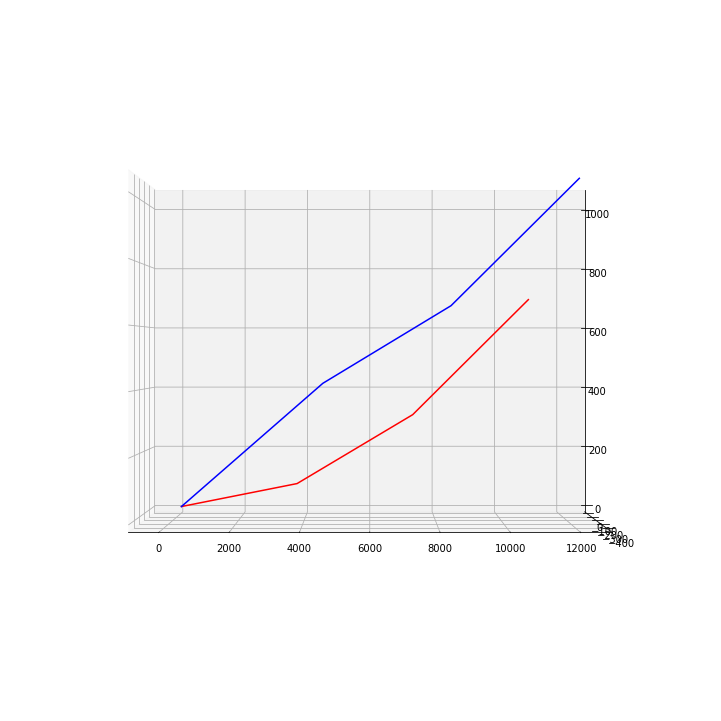

In [154]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]
# for j in range(len(fin.y.T)):
j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.view_init(-30,-30)
ax.view_init(0,-90)
# ax.set_xlim([0, 5])
# ax.set_ylim([0, 5])
plt.show()

In [155]:
X,Y,Z

(array([    0.        ,  4652.67257515,  8335.31072414, 12020.12269498]),
 array([   0.        , -458.08844004, -456.47491039, -456.52295911]),
 array([   0.        ,  424.26258365,  659.14368732, 1044.62411279]))

In [156]:
X0,Y0,Z0

(array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446]),
 array([0., 0., 0., 0.]),
 array([  0.        ,  77.06804645, 308.4070593 , 694.42189511]))

In [157]:
us=fin.T

In [158]:
t=np.arange(tspan[0],tspan[1],tspan[1]/len(us.T))

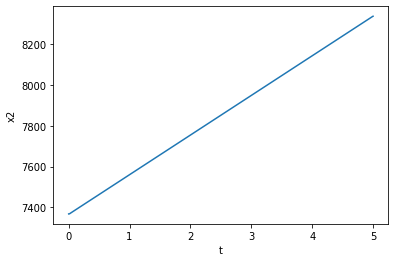

In [159]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

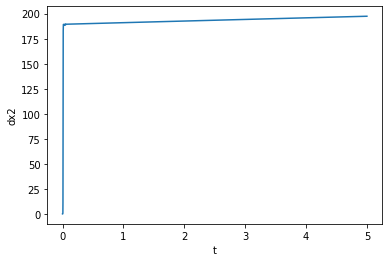

In [160]:
plt.plot(t,us.T[:,6] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

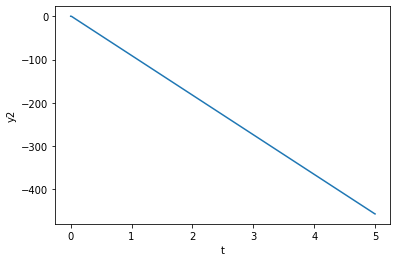

In [161]:
plt.plot(t,us.T[:,10] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

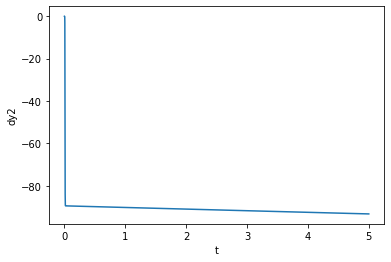

In [162]:
plt.plot(t,us.T[:,14] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

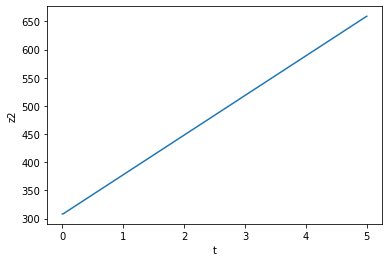

In [163]:
plt.plot(t,us.T[:,18] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

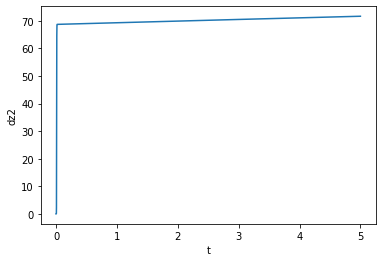

In [164]:
plt.plot(t,us.T[:,22] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

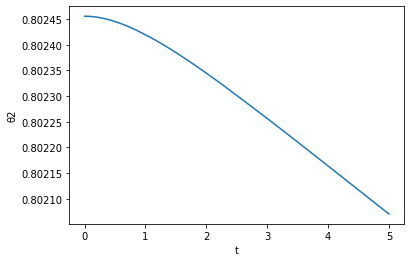

In [165]:
plt.plot(t,us.T[:,34],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

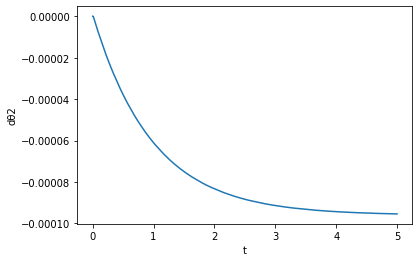

In [166]:
plt.plot(t,us.T[:,38] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

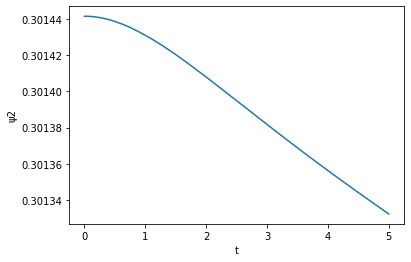

In [167]:
plt.plot(t,us.T[:,42],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

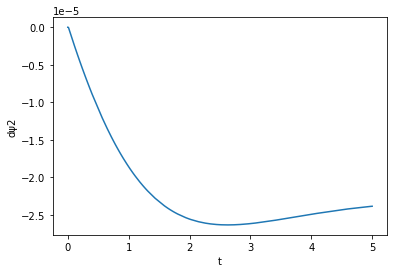

In [168]:
plt.plot(t,us.T[:,46] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()